In [2]:
import snowflake.connector
import pandas as pd
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.metrics import roc_auc_score, recall_score, precision_score


In [3]:
def create_snowflake_connection():
    return snowflake.connector.connect(
    user= 'general_access',
    password= 'Xylo-data-bi-844tag',
    account= 'hba10191.us-east-1',
    warehouse= 'COMPUTE_WH',
    database='PROD_DB',
    schema='ADHOC',
    role= 'BI_ROLE'
    )

def get_data(conn, query):
    return pd.read_sql(query, conn)

conn = create_snowflake_connection()

# Query

In [4]:
query = """
with data1 as (
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2023-06-01' and date(a.CREATED_AT) < '2024-11-01'
and status = 'returned'

UNION

select a.ID, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID, a.AMOUNT, a.CREATED_AT, a.UPDATED_AT, a.STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS" b on a.id=b.PULL_FUNDS_REQUEST_ID
where b.event='rejected'
and b.description NOT LIKE ('%Automatically%')
and b.description NOT LIKE ('%External account not linked%')
and b.description NOT LIKE ('%External account in Error Status%')
and b.description NOT LIKE ('%Funds no longer available%')
and b.description NOT LIKE ('%External account name mismatch%')
and b.description NOT LIKE ('%Transfer was rejected because account is frozen%')
//and description LIKE ('%Doubtful Collectibility- Previously Returned Items%')
and a.CREATED_AT >='2023-06-01' and a.CREATED_AT <'2024-11-01'

UNION
  
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2023-06-01' and date(a.CREATED_AT) < '2024-11-01'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,data2_bank_risk as(
select a.*,
from data1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)

,data2 as(
select a.*,
from data1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
  and date(a.CREATED_AT) >= '2023-09-01' and date(a.CREATED_AT) < '2024-11-01'
)

---------- Running Balance ----------

,data_adb_1 as (
select ID,
  avg(day_end_balance) as avg_running_balance_past30d, 
  stddev(day_end_balance) as stddev_running_balance_past30d,
  sum(CASE WHEN day_end_balance < 0 THEN  1 ELSE 0 end) AS od_count_past30d,
  sum(CASE WHEN day_end_balance = 0 THEN  1 ELSE 0 end) AS zero_balance_count_past30d,
from "PROD_DB"."DATA"."BALANCES_DAILY" b inner join data2 a on a.business_id = b.business_id
where date >= DATEADD(d,-30,a.CREATED_AT) and date <= date(a.CREATED_AT)
group by 1
)

,data_adb_2 as (
select a.ID, day_end_balance as rb_at_deposit
from data2 a left join "PROD_DB"."DATA"."BALANCES_DAILY" b
on a.business_id = b.business_id and b.date = date(a.CREATED_AT)
)

,final_rb as (
select a.*, b.avg_running_balance_past30d, b.stddev_running_balance_past30d, 
b.od_count_past30d, b.zero_balance_count_past30d, c.rb_at_deposit
from data2 a inner join data_adb_1 b on a.id = b.id
inner join data_adb_2 c on a.id = c.id
)


-----------------BUSINESS DETAILS-------------------

,BUSINESS_DETAIL as
(
select *
from "PROD_DB"."DATA"."BUSINESSES"
),


APPLICATION_DETAIL as 
(
select *
from "PROD_DB"."DATA"."APPLICATIONS"
)

, final_query_business as
( select base.BUSINESS_ID,
B.application_id,
B.business_type,
B.ein_ssn
from BUSINESS_DETAIL base
left join APPLICATION_DETAIL B
on base.APPLICATION_ID = B.APPLICATION_ID
)

,data_business as(
select a.*, b.* exclude(business_id) from final_rb a inner join final_query_business b
on a.business_id = b.business_id
)

-----------------AGE OF BUSINESS-------------------

,data_age as(
select a.*, DATEDIFF(day, BUSINESS_CREATED_AT, CREATED_AT)/31 as age_business_months
from data_business a inner join "PROD_DB"."DATA"."BUSINESSES" b
on a.business_id = b.business_id
)

--------Transactions---------

-- Past 30 Days --

, pfr_past_txn_past30d as(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
from prod_db.data.transactions a right join data2 b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.created_at) > 0 
and datediff(day, a.transaction_date, b.created_at) <= 30
and a.status='active'
)


, pfr_past_txn_agg_past30d as (
select pfr_id, pfr_status,
sum(is_card_txn) as card_txn_count_past30d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past30d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past30d,
sum(is_ach_c) as ach_c_count_past30d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past30d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past30d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past30d,
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_30d,
sum(is_debit) as debit_txn_count_past30d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past30d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past30d,
from pfr_past_txn_past30d
group by 1,2
)

-- Past 10 Days --

, pfr_past_txn_past10d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
from prod_db.data.transactions a right join data2 b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.created_at) > 0 
and datediff(day, a.transaction_date, b.created_at) <= 10
and a.status='active'
)

, pfr_past_txn_agg_past10d as (
select pfr_id, pfr_status,
sum(is_debit) as debit_txn_count_past10d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past10d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past10d,
sum(is_ach_c) as ach_c_count_past10d,
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_10d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past10d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past10d,
from pfr_past_txn_past10d
group by 1,2
)

-- Past 2 Days --

, pfr_past_txn_past2d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
from prod_db.data.transactions a right join data2 b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.created_at) > 0 
and datediff(day, a.transaction_date, b.created_at) <= 10
and a.status='active'
)

, pfr_past_txn_agg_past2d as (
select pfr_id, pfr_status,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past2d,
sum(case when is_card_txn=1 then abs(amount) else null end) as card_txn_cnt_past2d,
from pfr_past_txn_past2d
group by 1,2
)

--------Returned/Rejected/Completed ACH---------

, all_pfr as (
select  a.ID, a.BUSINESS_ID, a.AMOUNT, a.CREATED_AT, updated_at, a.STATUS,
CASE WHEN status = 'completed' THEN 1 ELSE 0 END as is_completed,
CASE WHEN status = 'returned' THEN 1 ELSE 0 END as is_returned,
CASE WHEN status = 'rejected' THEN 1 ELSE 0 END as is_rejected
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.created_at) > '2023-08-01' and date(a.created_at) < '2024-11-01'

)

, past30d_ach as (
select a.*,
past.id as past30d_id,
past.BUSINESS_ID AS past30d_BUSINESS_ID,
past.amount as past30d_amount,
past.status as past30d_status,
from all_pfr a inner join all_pfr past
on a.business_id = past.business_id
and past.updated_at < a.created_at
and past.updated_at >= DATEADD(d,-30,a.CREATED_AT)
//and past.updated_at >=  a.created_at - INTERVAL '30 day'
)

,past30d_complete_info as (
select BUSINESS_ID, id,
count(past30d_id) as past30d_ach_count,
stddev(past30d_amount) as completed_past30d_std_ach_amount,
avg(past30d_amount) as past30d_avg_ach_amount,
from past30d_ach
group by 1,2
)

,past30d_returned_info as (
select BUSINESS_ID, id,
count(past30d_id) as past30d_returned_ach, 
avg(past30d_amount) as returned_past30d_avg_ach_amount
from past30d_ach
where past30d_status = 'returned'
group by 1,2
)

, past30d_rejected_info as (
select BUSINESS_ID, id,
avg(past30d_amount) as rejected_past30d_avg_ach_amount,
from past30d_ach
where past30d_status = 'rejected'
group by 1,2
)

--------Bank Risk---------

, external_bank as (
select distinct a.id, b.bank_name, date(a.CREATED_AT) as external_bank_date
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."EXTERNAL_ACCOUNTS" b on a.EXTERNAL_ACCOUNT_ID = b.ID
where date(a.CREATED_AT) >= '2023-06-01' and date(a.CREATED_AT) < '2024-11-01'
)

,data3 as (
select a.*, DATE_TRUNC(month, created_at) AS bank_date, b.BANK_NAME
from data2_bank_risk a inner join external_bank b 
on a.id = b.id
)

,bank_risk_1 as (
select '2024-10-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-07-01' and date(CREATED_AT) < '2024-10-01'
group by 1
)
UNION  

select '2024-09-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-06-01' and date(CREATED_AT) < '2024-09-01'
group by 1
)
UNION


select '2024-08-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-05-01' and date(CREATED_AT) < '2024-08-01'
group by 1
)
UNION

select '2024-07-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-04-01' and date(CREATED_AT) < '2024-07-01'
group by 1
)
UNION

select '2024-06-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-03-01' and date(CREATED_AT) < '2024-06-01'
group by 1
)
UNION

select '2024-05-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-02-01' and date(CREATED_AT) < '2024-05-01'
group by 1
)
UNION

select '2024-04-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-01-01' and date(CREATED_AT) < '2024-04-01'
group by 1
)
UNION

select '2024-03-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-12-01' and date(CREATED_AT) < '2024-03-01'
group by 1
)
UNION

select '2024-02-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-11-01' and date(CREATED_AT) < '2024-02-01'
group by 1
)
UNION

select '2024-01-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-10-01' and date(CREATED_AT) < '2024-01-01'
group by 1
)
UNION

select '2023-12-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-09-01' and date(CREATED_AT) < '2023-12-01'
group by 1
)
UNION

select '2023-11-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-08-01' and date(CREATED_AT) < '2023-11-01'
group by 1
)
UNION

select '2023-10-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-07-01' and date(CREATED_AT) < '2023-10-01'
group by 1
)
UNION

select '2023-09-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-06-01' and date(CREATED_AT) < '2023-09-01'
group by 1
)
)

,bank_risk_2 as (
select a.ID, a.BANK_NAME, b.BANK_RISK from data3 a left outer join bank_risk_1 b
on a.bank_date = b.bank_date and a.bank_name = b.bank_name
where date(a.CREATED_AT) >= '2023-09-01' and date(a.CREATED_AT) < '2024-11-01'
)

--------Aggregate---------

select a.* exclude(TRANSACTION_ID, USER_ID, EXTERNAL_ACCOUNT_ID, APPLICATION_ID),
COALESCE(card_txn_count_past30d,0) as card_txn_count_past30d,
COALESCE(card_txn_median_past30d,0) as card_txn_median_past30d,
COALESCE(card_txn_avg_past30d,0) as card_txn_avg_past30d,
COALESCE(ach_c_count_past30d,0) as ach_c_count_past30d,
COALESCE(ach_c_median_past30d,0) as ach_c_median_past30d,
COALESCE(ach_c_avg_past30d,0) as ach_c_avg_past30d,
COALESCE(ach_c_std_past30d,0) as ach_c_std_past30d,
debit_by_credit_past_30d,
//debit_txn_count_past30d,
COALESCE(ach_d_median_past30d,0) as ach_d_median_past30d,
COALESCE(ach_d_avg_past30d,0) as ach_d_avg_past30d,

//debit_txn_count_past10d,
//ach_c_median_past10d,
//card_txn_median_past10d,
//ach_c_count_past10d,
debit_by_credit_past_10d,
COALESCE(card_txn_avg_past10d,0) as card_txn_avg_past10d,
//ach_c_avg_past10d,

COALESCE(card_txn_median_past2d,0) as card_txn_median_past2d,
COALESCE(card_txn_cnt_past2d,0) as card_txn_cnt_past2d,

DIV0NULL(card_txn_median_past10d,card_txn_median_past30d) as card_txn_median_past10by30d,
DIV0NULL(ach_c_count_past10d,ach_c_count_past30d) as ach_c_count_past10by30d,
DIV0NULL(ach_c_avg_past10d,ach_c_avg_past30d) as ach_c_avg_past10by30d,
DIV0NULL(debit_txn_count_past10d,debit_txn_count_past30d) as debit_txn_count_past10by30d,
DIV0NULL(ach_c_median_past10d,ach_c_median_past30d) as ach_c_median_past10by30d,

COALESCE(past30d_ach_count,0) as past30d_ach_count,
COALESCE(completed_past30d_std_ach_amount,0) as completed_past30d_std_ach_amount,
COALESCE(past30d_avg_ach_amount,0) as past30d_avg_ach_amount,

COALESCE(past30d_returned_ach,0) as past30d_returned_ach, 
COALESCE(returned_past30d_avg_ach_amount,0) as returned_past30d_avg_ach_amount,

COALESCE(rejected_past30d_avg_ach_amount,0) as rejected_past30d_avg_ach_amount,

COALESCE(bank_risk,0) as bank_risk

from data_age a 
left outer join pfr_past_txn_agg_past30d b on a.id = b.pfr_id
left outer join pfr_past_txn_agg_past10d c on a.id = c.pfr_id
left outer join pfr_past_txn_agg_past2d d on a.id = d.pfr_id
left outer join past30d_complete_info e on a.id = e.id
left outer join past30d_returned_info f on a.id = f.id
left outer join past30d_rejected_info g on a.id = g.id
left outer join bank_risk_2 h on a.id=h.id

"""

In [5]:
df = get_data(conn, query)

In [6]:
df.columns = df.columns.str.lower()
df.head(2)

,id,business_id,amount,created_at,updated_at,status,target,avg_running_balance_past30d,stddev_running_balance_past30d,od_count_past30d,zero_balance_count_past30d,rb_at_deposit,business_type,ein_ssn,age_business_months,card_txn_count_past30d,card_txn_median_past30d,card_txn_avg_past30d,ach_c_count_past30d,ach_c_median_past30d,ach_c_avg_past30d,ach_c_std_past30d,debit_by_credit_past_30d,ach_d_median_past30d,ach_d_avg_past30d,debit_by_credit_past_10d,card_txn_avg_past10d,card_txn_median_past2d,card_txn_cnt_past2d,card_txn_median_past10by30d,ach_c_count_past10by30d,ach_c_avg_past10by30d,debit_txn_count_past10by30d,ach_c_median_past10by30d,past30d_ach_count,completed_past30d_std_ach_amount,past30d_avg_ach_amount,past30d_returned_ach,returned_past30d_avg_ach_amount,rejected_past30d_avg_ach_amount,bank_risk
0,6c1e7f9c-d886-4cca-8f27-8a1ce552256f,7fe6a53b-8014-4102-9271-9891b827ae7c,600.0,2024-07-09 01:42:12.105000+00:00,2024-07-10 00:01:31.344228+00:00,completed,0,82.092,241.697841,0,0,1222.68,llc,0,27.967742,0,0.0,0.0,1,600.63,600.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,1.0,0,0.0,0.0,0,0.0,0.0,2
1,2ad1a66d-7492-48d1-963a-f1214e400095,7e015b0f-1bd1-404b-84a0-76171f188085,50.0,2024-08-14 21:53:56.491000+00:00,2024-08-16 18:01:06.918547+00:00,completed,0,0.000,0.000000,0,22,0.00,llc,0,0.677419,0,0.0,0.0,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0,0.0,0.0,0,0.0,0.0,1


# MOB >6 months

In [7]:
df1 = df.loc[(df['age_business_months']>6)]
df1.shape

(121332, 41)

In [8]:
#Cast Float
df1[['ein_ssn']] = df1[['ein_ssn']].astype(float)

#Checking For Null Values
df1.isnull().sum()

#Stats
df1.describe()

,amount,target,avg_running_balance_past30d,stddev_running_balance_past30d,od_count_past30d,zero_balance_count_past30d,rb_at_deposit,ein_ssn,age_business_months,card_txn_count_past30d,card_txn_median_past30d,card_txn_avg_past30d,ach_c_count_past30d,ach_c_median_past30d,ach_c_avg_past30d,ach_c_std_past30d,debit_by_credit_past_30d,ach_d_median_past30d,ach_d_avg_past30d,debit_by_credit_past_10d,card_txn_avg_past10d,card_txn_median_past2d,card_txn_cnt_past2d,card_txn_median_past10by30d,ach_c_count_past10by30d,ach_c_avg_past10by30d,debit_txn_count_past10by30d,ach_c_median_past10by30d,past30d_ach_count,completed_past30d_std_ach_amount,past30d_avg_ach_amount,past30d_returned_ach,returned_past30d_avg_ach_amount,rejected_past30d_avg_ach_amount,bank_risk
count,121332.000000,121332.000000,121332.000000,121331.000000,121332.000000,121332.000000,1.213290e+05,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,50997.000000,121332.000000,91165.000000,121332.000000,61295.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000,121332.000000
mean,633.788822,0.017885,2875.783970,747.297624,0.394669,0.929689,3.032634e+03,0.142633,24.029004,6.785811,36.325003,21.655972,26.271412,488.735680,162.171458,321.434613,2.319083,343.382520,177.557316,1.309540,19.166167,29.231286,183.601822,1.570542,0.241543,0.837545,0.286791,10.804263,1.961873,99.140392,410.614348,0.010022,4.690235,53.788776,1.317311
std,1074.280977,0.132533,13646.701043,2292.269902,2.393570,4.602348,1.407295e+04,0.349700,11.510135,15.717625,139.746915,53.079631,1588.664805,1668.641323,434.841353,1408.046686,3.808651,1014.617593,548.276744,2.983878,66.624545,130.163823,708.050168,8.031458,0.303807,0.999973,0.279499,683.095718,3.582804,363.360317,895.868009,0.109689,96.410986,383.600622,0.601306
min,0.010000,0.000000,-12524.371333,0.000000,0.000000,0.000000,-1.874405e+04,0.000000,6.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,0.000000,89.298417,44.929061,0.000000,0.000000,6.953000e+01,0.000000,13.645161,0.000000,0.000000,0.000000,1.000000,5.000000,2.500000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.819700,0.000000,0.000000,0.000000,0.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,250.000000,0.000000,420.538667,190.605776,0.000000,0.000000,4.343900e+02,0.000000,24.129032,1.000000,10.500000,5.253095,2.000000,112.500000,44.600000,16.276434,1.166667,56.440000,22.683445,0.000000,0.000000,0.000000,0.000000,1.000000,0.100000,0.740741,0.254545,1.000000,1.000000,0.000000,75.000000,0.000000,0.000000,0.000000,1.000000
75%,800.000000,0.000000,1813.442250,643.958640,0.000000,0.000000,1.984540e+03,0.000000,32.935484,7.000000,32.000000,25.583125,5.000000,461.000000,163.358895,247.487373,3.000000,300.000000,155.635782,1.500000,17.360000,22.990000,87.662500,1.282037,0.400000,1.254893,0.444444,1.191887,2.000000,31.900968,417.500000,0.000000,0.000000,0.000000,2.000000
max,30032.000000,1.000000,936491.818667,181838.430662,30.000000,30.000000,1.003184e+06,1.000000,69.935484,493.000000,5000.000000,4000.000000,123150.000000,201081.880000,50000.000000,142296.545757,112.000000,70000.000000,44000.000000,142.000000,3869.710000,5000.000000,49844.400000,621.160410,1.000000,33.000000,1.000000,92791.666667,66.000000,15588.457268,30000.000000,5.000000,5000.000000,20000.000000,3.000000


[Text(0.5, 1.0, 'Return Rate vs bank_risk')]

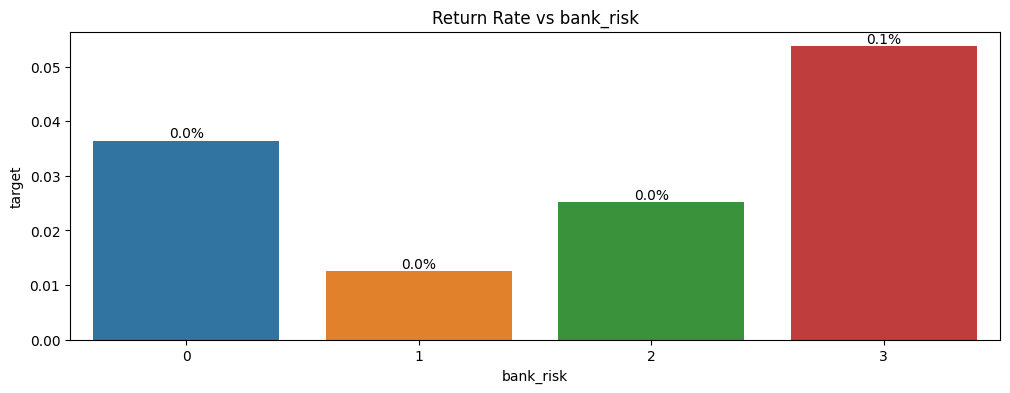

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=df1, x='bank_risk', y='target', ax=ax, ci=None)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
ax.set(title='Return Rate vs bank_risk')

# Modelling

In [10]:
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
import warnings
warnings.filterwarnings("ignore")

# Classifier
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score,f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

### Define Eval Metrics

In [11]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Test Recall', recall_score(y_test, y_pred_test,pos_label=1))
    print('Test Precision', precision_score(y_test, y_pred_test,pos_label=1))
    print('Test F1', f1_score(y_test, y_pred_test,pos_label=1))
    print('Test ROC_AUC',roc_auc_score(y_test, y_pred_test))
    print('Test Accuracy',accuracy_score(y_test, y_pred_test))
    print('Test Confusion Matrix',confusion_matrix(y_test, y_pred_test))
    ConfusionMatrix = confusion_matrix(y_test, y_pred_test)
    defaulters = ConfusionMatrix[1,0]
    success = ConfusionMatrix[0,0]
    default_rate = (ConfusionMatrix[1,0]) / (ConfusionMatrix[1,0] + ConfusionMatrix[0,0])
    print('Test Default Rate : ', default_rate)
    ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='BuPu',fmt=".1f",cbar=False)
    ax.set_title('Confusion Matrix for Test');
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(['Completed','Return'])
    ax.yaxis.set_ticklabels(['Completed','Return'])
    plt.show()
    
    print()
    
    print('Train Recall', recall_score(y_train, y_pred_train,pos_label=1))
    print('Train Precision', precision_score(y_train, y_pred_train,pos_label=1))
    print('Train F1', f1_score(y_train, y_pred_train,pos_label=1))
    print('Train ROC_AUC',roc_auc_score(y_train, y_pred_train))
    print('Train Accuracy',accuracy_score(y_train, y_pred_train))
    print('Train Confusion Matrix',confusion_matrix(y_train, y_pred_train))
    ConfusionMatrix = confusion_matrix(y_train, y_pred_train)
    defaulters = ConfusionMatrix[1,0]
    success = ConfusionMatrix[0,0]
    default_rate = (ConfusionMatrix[1,0]) / (ConfusionMatrix[1,0] + ConfusionMatrix[0,0])
    print('Train Default Rate : ', default_rate)
    ax = sns.heatmap(ConfusionMatrix, annot=True, fmt=".1f", cmap='BuPu',cbar=False)
    ax.set_title('Confusion Matrix for Train');
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(['Completed','Return'])
    ax.yaxis.set_ticklabels(['Completed','Return'])
    plt.show()

In [24]:
df2 = df1.copy()

model_cat = df2.loc[(df2['created_at']>='2023-09-01') & (df2['created_at']<'2024-07-01')]
oot_cat = df2.loc[(df2['created_at']>='2024-07-01') & (df2['created_at']<'2024-11-01')]


X = model_cat[['bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_d_avg_past30d','stddev_running_balance_past30d','ach_d_median_past30d','amount','debit_by_credit_past_10d','ach_c_count_past30d','past30d_ach_count','card_txn_median_past2d','ach_c_count_past10by30d','past30d_avg_ach_amount','od_count_past30d','card_txn_median_past30d','returned_past30d_avg_ach_amount','card_txn_avg_past10d','ach_c_median_past30d','zero_balance_count_past30d','ach_c_avg_past30d','card_txn_median_past10by30d','ach_c_avg_past10by30d']]
y = model_cat['target']

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, 
                                                    random_state=42)

x_oot = oot_cat[['bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_d_avg_past30d','stddev_running_balance_past30d','ach_d_median_past30d','amount','debit_by_credit_past_10d','ach_c_count_past30d','past30d_ach_count','card_txn_median_past2d','ach_c_count_past10by30d','past30d_avg_ach_amount','od_count_past30d','card_txn_median_past30d','returned_past30d_avg_ach_amount','card_txn_avg_past10d','ach_c_median_past30d','zero_balance_count_past30d','ach_c_avg_past30d','card_txn_median_past10by30d','ach_c_avg_past10by30d']]
y_oot = oot_cat['target']


In [25]:
x_train.head(2)

,bank_risk,avg_running_balance_past30d,rb_at_deposit,card_txn_count_past30d,debit_by_credit_past_30d,ach_d_avg_past30d,stddev_running_balance_past30d,ach_d_median_past30d,amount,debit_by_credit_past_10d,ach_c_count_past30d,past30d_ach_count,card_txn_median_past2d,ach_c_count_past10by30d,past30d_avg_ach_amount,od_count_past30d,card_txn_median_past30d,returned_past30d_avg_ach_amount,card_txn_avg_past10d,ach_c_median_past30d,zero_balance_count_past30d,ach_c_avg_past30d,card_txn_median_past10by30d,ach_c_avg_past10by30d
128876,1,177.256000,163.85,7,3.5,0.0,80.199893,0.0,200.0,0.0,1,1,0.0,0.0,200.0,0,27.29,0.0,0.0,200.0,0,22.222222,NaN,NaN
91299,1,907.523333,2099.87,1,0.0,2.6,227.949374,5.2,1250.0,0.0,0,0,0.0,0.0,0.0,0,88.64,0.0,0.0,0.0,0,0.000000,NaN,NaN


### Hyper Parameter Optimization

In [74]:
import optuna

def hyper_eval(cb, x_train, x_test, y_test, y_train):
    y_train_pred = cb.predict_proba(x_train)
    y_test_pred = cb.predict_proba(x_test)

    y_train_pred1 = pd.DataFrame(data = y_train_pred, columns=['co_prob','canc_prob'])
    y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
    
    y_test1 = pd.DataFrame(data = y_test, columns=['target'])
    y_train1 = pd.DataFrame(data = y_train, columns=['target'])
    
    # Test at different cutoffs
    prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    test_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision_test', 'Recall_test']

    for bin in prob_threshold:
        test_ls.append(calculate_at_threshold(bin, y_test1['target'], y_test_pred1['canc_prob']))
    metric_df_test = pd.DataFrame(test_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_test.index.name = 'Threshold'
    metric_df_test = metric_df_test.reset_index()
    metric_df_test = metric_df_test[['Threshold','Precision_test','Recall_test']]


    # Train at different cutoffs
    prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    train_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision_train', 'Recall_train']


    for bin in prob_threshold:
        train_ls.append(calculate_at_threshold(bin, y_train1['target'], y_train_pred1['canc_prob']))
    metric_df_train = pd.DataFrame(train_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_train.index.name = 'Threshold'
    metric_df_train = metric_df_train.reset_index()
    metric_df_train = metric_df_train[['Threshold','Precision_train','Recall_train']]
    
    final = pd.merge(metric_df_test,metric_df_train, on = 'Threshold')
    final = final.loc[final['Threshold']==0.1]
    
    return final


[W 2025-01-06 15:04:37,863] Trial 58 failed with parameters: {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:04:37,864] Trial 58 failed with value ({'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.225806     0.216292         0.293116      0.290028).


In [75]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.01, 0.2, 0.05)
#     param['depth'] = trial.suggest_int('depth', 2, 6) 
    param['depth'] = trial.suggest_discrete_uniform('depth', 2, 6, 1.0)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 40.0, 100.0, 30.0)
#     param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
#     param['grow_policy'] = 'Depthwise'
    param['iterations'] = trial.suggest_categorical('iterations', [400, 500, 700])
#     param['use_best_model'] = True
    param['eval_metric'] = 'AUC'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 50
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    cb = CatBoostClassifier(**param)
    cb.fit(x_train.copy(), y_train.copy(),
                  eval_set=[(x_test.copy(), y_test.copy())],
                  early_stopping_rounds=100)
        
    
    return param,hyper_eval(cb, x_train, x_test, y_test, y_train)

In [76]:
%%time
study = optuna.create_study(study_name='catboost-seed')
study.optimize(objective, n_trials=100, n_jobs=-1, timeout=24000)

[I 2025-01-06 15:04:42,164] A new study created in memory with name: catboost-seed
[W 2025-01-06 15:04:51,632] Trial 4 failed with parameters: {'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:04:51,637] Trial 4 failed with value ({'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.224299     0.202247         0.259124      0.249298).
[W 2025-01-06 15:04:52,620] Trial 1 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 4.0, 'l2_leaf_reg': 40.0, 'iterations': 400} because of the following error: The value {'learning_rate

[W 2025-01-06 15:05:08,570] Trial 11 failed with value ({'learning_rate': 0.16, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1         0.22314     0.227528         0.362608      0.382725).
[W 2025-01-06 15:05:09,625] Trial 14 failed with parameters: {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:05:09,646] Trial 14 failed with value ({'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1

[W 2025-01-06 15:05:24,368] Trial 17 failed with parameters: {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:05:24,370] Trial 17 failed with value ({'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.219373     0.216292         0.328581      0.339888).
[W 2025-01-06 15:05:27,038] Trial 26 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 400, '

[W 2025-01-06 15:05:43,655] Trial 32 failed with value ({'learning_rate': 0.16, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.229412     0.219101         0.322092      0.328652).
[W 2025-01-06 15:05:48,249] Trial 35 failed with parameters: {'learning_rate': 0.16, 'depth': 6.0, 'l2_leaf_reg': 70.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.16, 'depth': 6.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:05:48,261] Trial 35 failed with value ({'learning_rate': 0.16, 'depth': 6.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1  

[W 2025-01-06 15:06:03,504] Trial 48 failed with parameters: {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:06:03,509] Trial 48 failed with value ({'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.216374     0.207865          0.30255      0.308287).
[W 2025-01-06 15:06:06,027] Trial 49 failed with parameters: {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_s

[W 2025-01-06 15:06:19,765] Trial 53 failed with parameters: {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:06:19,770] Trial 53 failed with value ({'learning_rate': 0.16, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.219373     0.216292         0.328581      0.339888).
[W 2025-01-06 15:06:21,336] Trial 55 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 5.0, 'l2_leaf_reg': 40.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 5.0, 'l2_leaf_reg': 40.0, 'iterations': 500, '

[W 2025-01-06 15:06:42,344] Trial 74 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.184906      0.13764         0.240484      0.195225).
[W 2025-01-06 15:06:42,757] Trial 73 failed with parameters: {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:06:42,761] Trial 73 failed with value ({'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_t

[W 2025-01-06 15:07:02,414] Trial 81 failed with parameters: {'learning_rate': 0.11, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.11, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:07:02,420] Trial 81 failed with value ({'learning_rate': 0.11, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.221557     0.207865         0.278056      0.273174).
[W 2025-01-06 15:07:03,531] Trial 87 failed with parameters: {'learning_rate': 0.01, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.01, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_sta

[W 2025-01-06 15:07:19,113] Trial 94 failed with value ({'learning_rate': 0.16, 'depth': 4.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.230088     0.219101         0.275466      0.269663).
[W 2025-01-06 15:07:22,457] Trial 96 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 15:07:22,460] Trial 96 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_te

CPU times: user 19min 12s, sys: 16.4 s, total: 19min 28s
Wall time: 2min 44s


In [20]:
x_train.head(1)

,age_business_months,bank_risk,avg_running_balance_past30d,rb_at_deposit,card_txn_count_past30d,debit_by_credit_past_30d,ach_d_avg_past30d,stddev_running_balance_past30d,ach_d_median_past30d,amount,debit_by_credit_past_10d,ach_c_count_past30d,past30d_ach_count,card_txn_median_past2d,ach_c_count_past10by30d,past30d_avg_ach_amount,od_count_past30d,card_txn_median_past30d,returned_past30d_avg_ach_amount,card_txn_avg_past10d,ach_c_median_past30d,zero_balance_count_past30d,ach_c_avg_past30d,card_txn_median_past10by30d,ach_c_avg_past10by30d,card_txn_cnt_past2d
128876,14.129032,1,177.256,163.85,7,3.5,0.0,80.199893,0.0,200.0,0.0,1,1,0.0,0.0,200.0,0,27.29,0.0,0.0,200.0,0,22.222222,NaN,NaN,0.0


### Model Iteration

In [26]:
categoricals = ['bank_risk']

cb = CatBoostClassifier(cat_features=categoricals,
                         eval_metric = 'AUC',
                         depth = 5,
                         iterations = 400,
                         l2_leaf_reg = 100,
                         learning_rate = 0.1,
                        random_state = 42,
                        use_best_model=True)

cb.fit(x_train, y_train, verbose = 1,eval_set = (x_test, y_test))

y_train_pred = cb.predict_proba(x_train)
y_test_pred = cb.predict_proba(x_test)

0:	test: 0.5390378	best: 0.5390378 (0)	total: 25.3ms	remaining: 10.1s
1:	test: 0.5294775	best: 0.5390378 (0)	total: 44.1ms	remaining: 8.77s
2:	test: 0.5940288	best: 0.5940288 (2)	total: 61.3ms	remaining: 8.11s
3:	test: 0.6437067	best: 0.6437067 (3)	total: 78.8ms	remaining: 7.8s
4:	test: 0.6656402	best: 0.6656402 (4)	total: 95.1ms	remaining: 7.51s
5:	test: 0.6700219	best: 0.6700219 (5)	total: 112ms	remaining: 7.35s
6:	test: 0.6859612	best: 0.6859612 (6)	total: 129ms	remaining: 7.23s
7:	test: 0.6854997	best: 0.6859612 (6)	total: 145ms	remaining: 7.12s
8:	test: 0.6912107	best: 0.6912107 (8)	total: 164ms	remaining: 7.11s
9:	test: 0.6910057	best: 0.6912107 (8)	total: 180ms	remaining: 7.03s
10:	test: 0.6985291	best: 0.6985291 (10)	total: 196ms	remaining: 6.94s
11:	test: 0.7000178	best: 0.7000178 (11)	total: 213ms	remaining: 6.89s
12:	test: 0.7018194	best: 0.7018194 (12)	total: 230ms	remaining: 6.85s
13:	test: 0.7033641	best: 0.7033641 (13)	total: 246ms	remaining: 6.79s
14:	test: 0.7025668	be

122:	test: 0.7564769	best: 0.7564975 (121)	total: 2.12s	remaining: 4.76s
123:	test: 0.7564248	best: 0.7564975 (121)	total: 2.13s	remaining: 4.75s
124:	test: 0.7566032	best: 0.7566032 (124)	total: 2.15s	remaining: 4.73s
125:	test: 0.7571254	best: 0.7571254 (125)	total: 2.17s	remaining: 4.71s
126:	test: 0.7580917	best: 0.7580917 (126)	total: 2.18s	remaining: 4.69s
127:	test: 0.7579851	best: 0.7580917 (126)	total: 2.2s	remaining: 4.67s
128:	test: 0.7580110	best: 0.7580917 (126)	total: 2.21s	remaining: 4.65s
129:	test: 0.7580564	best: 0.7580917 (126)	total: 2.23s	remaining: 4.63s
130:	test: 0.7586124	best: 0.7586124 (130)	total: 2.25s	remaining: 4.61s
131:	test: 0.7586425	best: 0.7586425 (131)	total: 2.26s	remaining: 4.59s
132:	test: 0.7586710	best: 0.7586710 (132)	total: 2.28s	remaining: 4.57s
133:	test: 0.7588160	best: 0.7588160 (133)	total: 2.3s	remaining: 4.56s
134:	test: 0.7588583	best: 0.7588583 (134)	total: 2.31s	remaining: 4.54s
135:	test: 0.7588436	best: 0.7588583 (134)	total: 2.3

242:	test: 0.7620845	best: 0.7620845 (242)	total: 4s	remaining: 2.59s
243:	test: 0.7620796	best: 0.7620845 (242)	total: 4.02s	remaining: 2.57s
244:	test: 0.7620814	best: 0.7620845 (242)	total: 4.03s	remaining: 2.55s
245:	test: 0.7620918	best: 0.7620918 (245)	total: 4.05s	remaining: 2.53s
246:	test: 0.7621164	best: 0.7621164 (246)	total: 4.06s	remaining: 2.52s
247:	test: 0.7622212	best: 0.7622212 (247)	total: 4.08s	remaining: 2.5s
248:	test: 0.7620368	best: 0.7622212 (247)	total: 4.1s	remaining: 2.48s
249:	test: 0.7620426	best: 0.7622212 (247)	total: 4.11s	remaining: 2.46s
250:	test: 0.7618824	best: 0.7622212 (247)	total: 4.12s	remaining: 2.45s
251:	test: 0.7618768	best: 0.7622212 (247)	total: 4.14s	remaining: 2.43s
252:	test: 0.7619773	best: 0.7622212 (247)	total: 4.15s	remaining: 2.41s
253:	test: 0.7622789	best: 0.7622789 (253)	total: 4.17s	remaining: 2.4s
254:	test: 0.7622728	best: 0.7622789 (253)	total: 4.18s	remaining: 2.38s
255:	test: 0.7623535	best: 0.7623535 (255)	total: 4.2s	re

366:	test: 0.7629190	best: 0.7634930 (304)	total: 5.89s	remaining: 529ms
367:	test: 0.7628164	best: 0.7634930 (304)	total: 5.9s	remaining: 513ms
368:	test: 0.7627860	best: 0.7634930 (304)	total: 5.92s	remaining: 497ms
369:	test: 0.7628574	best: 0.7634930 (304)	total: 5.94s	remaining: 481ms
370:	test: 0.7628512	best: 0.7634930 (304)	total: 5.95s	remaining: 465ms
371:	test: 0.7628692	best: 0.7634930 (304)	total: 5.97s	remaining: 449ms
372:	test: 0.7628808	best: 0.7634930 (304)	total: 5.98s	remaining: 433ms
373:	test: 0.7628818	best: 0.7634930 (304)	total: 6s	remaining: 417ms
374:	test: 0.7628846	best: 0.7634930 (304)	total: 6.01s	remaining: 401ms
375:	test: 0.7628834	best: 0.7634930 (304)	total: 6.03s	remaining: 385ms
376:	test: 0.7628828	best: 0.7634930 (304)	total: 6.04s	remaining: 368ms
377:	test: 0.7629348	best: 0.7634930 (304)	total: 6.05s	remaining: 352ms
378:	test: 0.7629348	best: 0.7634930 (304)	total: 6.07s	remaining: 336ms
379:	test: 0.7629475	best: 0.7634930 (304)	total: 6.09s

### Importance

In [27]:
# cb.get_feature_importance()
print(cb.get_feature_importance())
arr_imp_cb = cb.get_feature_importance()
pd.DataFrame(arr_imp_cb)

[15.48955841  5.83598995 13.42468988  2.72312194  1.17678793  2.67959957
  4.1591515   1.38666062 12.36321157  2.84402198  1.5522372   6.00069486
  0.97995915  2.34920362  6.86577787  3.10985435  1.5136361   5.01638006
  0.70250963  1.68841562  2.8346853   3.03549975  0.71488547  1.55346766]


,0
0,15.489558
1,5.835990
2,13.424690
3,2.723122
4,1.176788
5,2.679600
6,4.159152
7,1.386661
8,12.363212
9,2.844022


### Scoring

In [28]:
y_train_pred = cb.predict_proba(x_train)
y_test_pred = cb.predict_proba(x_test)
y_oot_pred = cb.predict_proba(x_oot)

y_train_pred1 = pd.DataFrame(data = y_train_pred, columns=['co_prob','canc_prob'])
y_train_pred_fin = np.where((y_train_pred1["canc_prob"]<0.08),0,1)

y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
y_test_pred_fin = np.where((y_test_pred1["canc_prob"]<0.08),0,1)

y_oot_pred1 = pd.DataFrame(data = y_oot_pred, columns=['co_prob','canc_prob'])
y_oot_pred_fin = np.where((y_oot_pred1["canc_prob"]<0.08),0,1)


### Metrics

In [29]:
from sklearn.metrics import precision_recall_curve,precision_score,confusion_matrix, recall_score, roc_curve, plot_roc_curve
def calculate_at_threshold(threshold, actual, predicted):
  p = np.where(predicted >= threshold, 1, 0)
  fp = np.sum((p == 1) & (actual == 0))
  tp = np.sum((p == 1) & (actual == 1))
  fn = np.sum((p == 0) & (actual == 1))
  tn = np.sum((p == 0) & (actual == 0))
  tpr = (tp)/(tp + fn)
  fpr = (fp)/(fp + tn)
  precision = (tp)/(tp + fp)
  recall = (tp)/(tp + fn)
  return fp,tp,fn,tn,tpr,fpr,precision, recall

### Metrics OOT

In [30]:
# OOT at different cutoffs
prob_threshold =[0.01,0.02,0.025,0.03,0.05,0.08,0.1,0.20,0.3,0.4]
oot_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

for bin in prob_threshold:
    oot_ls.append(calculate_at_threshold(bin, oot_cat['target'], y_oot_pred1['canc_prob']))
metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_oot.index.name = 'Threshold'
metric_df_oot = metric_df_oot.reset_index()
metric_df_oot

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.010,17783,322,68,16329,0.825641,0.521312,0.017785,0.825641
1,0.020,6435,211,179,27677,0.541026,0.188643,0.031748,0.541026
2,0.025,4577,181,209,29535,0.464103,0.134176,0.038041,0.464103
3,0.030,3192,151,239,30920,0.387179,0.093574,0.045169,0.387179
4,0.050,1238,97,293,32874,0.248718,0.036292,0.072659,0.248718
5,0.080,525,65,325,33587,0.166667,0.015390,0.110169,0.166667
6,0.100,340,45,345,33772,0.115385,0.009967,0.116883,0.115385
7,0.200,73,28,362,34039,0.071795,0.002140,0.277228,0.071795
8,0.300,29,15,375,34083,0.038462,0.000850,0.340909,0.038462
9,0.400,9,8,382,34103,0.020513,0.000264,0.470588,0.020513


### Amount blocked at different cutoffs (OOT)

In [31]:
# OOT Data
dummy1 = oot_cat[['amount','target']]
dummy1 = dummy1.reset_index()
dummy2 = pd.merge(dummy1, y_oot_pred1, left_index=True, right_index=True)

print('OOT All')
print()
prob_threshold =[0.0,0.01,0.02,0.025,0.03,0.05,0.08,0.1,0.20,0.3,0.4]
for bin in prob_threshold:
    dummy3 = dummy2.loc[dummy2['canc_prob']>=bin]
    print(dummy3.amount.sum())

print()    
print('OOT Fraud')
print()
for bin in prob_threshold:
    dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==1)]
    print(dummy3.amount.sum())

print()
print('OOT Non Fraud')
print()
for bin in prob_threshold:
    dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==0)]
    print(dummy3.amount.sum())

OOT All

21744227.41
17396853.79
9617814.22
7443951.51
5684475.14
2139310.2
864894.7100000001
611558.9
122324.23000000001
46667.86
28441.86

OOT Fraud

244608.06999999998
228884.19999999998
172282.08000000002
148591.63999999998
136203.13
89817.68000000001
65189.70000000001
49437.880000000005
28687.0
24476.0
16726.0

OOT Non Fraud

21499619.34
17167969.590000004
9445532.14
7295359.87
5548272.01
2049492.52
799705.0099999999
562121.02
93637.23000000001
22191.86
11715.86


### Capture Rate (OOT)

In [32]:
dummy2['flag'] = np.where((dummy2['canc_prob'] >= 0) &(dummy2['canc_prob'] < 0.01), '1',
                          np.where((dummy2['canc_prob'] >= 0.01) &(dummy2['canc_prob'] < 0.025), '2',
                          np.where((dummy2['canc_prob'] >= 0.025) &(dummy2['canc_prob'] < 0.06), '3',
                          np.where((dummy2['canc_prob'] >= 0.06) &(dummy2['canc_prob'] < 0.15), '4',
                          np.where((dummy2['canc_prob'] >= 0.15) &(dummy2['canc_prob'] < 0.3), '5',
                          np.where((dummy2['canc_prob'] >= 0.3) &(dummy2['canc_prob'] < 1), '6',
#                           np.where((dummy2['canc_prob'] >= 0.25) &(dummy2['canc_prob'] < 1.1), '7',
                          '0'))))))

dummy2.groupby('flag').count()

,index,amount,target,co_prob,canc_prob
flag,,,,,
1,16397,16397,16397,16397,16397
2,13347,13347,13347,13347,13347
3,3820,3820,3820,3820,3820
4,763,763,763,763,763
5,131,131,131,131,131
6,44,44,44,44,44


In [33]:
dummy2.groupby('flag')['target'].sum()

flag
1     68
2    141
3    100
4     50
5     16
6     15
Name: target, dtype: int64

### Metrics (Train)

In [34]:
# Train at different cutoffs
prob_threshold =[0.01,0.02,0.025,0.03,0.05,0.08,0.1,0.20,0.3,0.4]
train_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

y_train1 = pd.DataFrame(data = y_train, columns=['target'])

model_cat_df = model_cat.copy()
for bin in prob_threshold:
    train_ls.append(calculate_at_threshold(bin, y_train1['target'], y_train_pred1['canc_prob']))
metric_df_train = pd.DataFrame(train_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_train.index.name = 'Threshold'
metric_df_train = metric_df_train.reset_index()
metric_df_train


,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.010,40708,1298,126,27332,0.911517,0.598295,0.030900,0.911517
1,0.020,16879,1018,406,51161,0.714888,0.248075,0.056881,0.714888
2,0.025,12411,898,526,55629,0.630618,0.182407,0.067473,0.630618
3,0.030,8869,801,623,59171,0.562500,0.130350,0.082834,0.562500
4,0.050,3569,567,857,64471,0.398174,0.052454,0.137089,0.398174
5,0.080,1504,430,994,66536,0.301966,0.022105,0.222337,0.301966
6,0.100,932,367,1057,67108,0.257725,0.013698,0.282525,0.257725
7,0.200,212,225,1199,67828,0.158006,0.003116,0.514874,0.158006
8,0.300,72,159,1265,67968,0.111657,0.001058,0.688312,0.111657
9,0.400,19,117,1307,68021,0.082163,0.000279,0.860294,0.082163


### Metrics (Test)

In [35]:
# Train at different cutoffs
prob_threshold =[0.01,0.02,0.025,0.03,0.05,0.08,0.1,0.20,0.3,0.4]
test_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

y_test1 = pd.DataFrame(data = y_test, columns=['target'])

# model_cat_df = model_cat.copy()
for bin in prob_threshold:
    test_ls.append(calculate_at_threshold(bin, y_test1['target'], y_test_pred1['canc_prob']))
metric_df_test = pd.DataFrame(test_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_test.index.name = 'Threshold'
metric_df_test = metric_df_test.reset_index()
metric_df_test

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.010,10135,308,48,6875,0.865169,0.595826,0.029493,0.865169
1,0.020,4161,233,123,12849,0.654494,0.244621,0.053027,0.654494
2,0.025,3073,202,154,13937,0.567416,0.180658,0.061679,0.567416
3,0.030,2150,173,183,14860,0.485955,0.126396,0.074473,0.485955
4,0.050,884,103,253,16126,0.289326,0.051969,0.104357,0.289326
5,0.080,383,72,284,16627,0.202247,0.022516,0.158242,0.202247
6,0.100,243,62,294,16767,0.174157,0.014286,0.203279,0.174157
7,0.200,69,27,329,16941,0.075843,0.004056,0.281250,0.075843
8,0.300,29,16,340,16981,0.044944,0.001705,0.355556,0.044944
9,0.400,12,11,345,16998,0.030899,0.000705,0.478261,0.030899


In [29]:
oot_cat_c = oot_cat.copy()
oot_cat_c = oot_cat_c.reset_index(drop=True)

oot_cat_pred = pd.merge(oot_cat_c, y_oot_pred1,left_index=True, right_index=True)
oot_cat_pred['flag'] = np.where((oot_cat_pred['canc_prob'] >= 0.025), '1','0')
oot_cat_pred.groupby(['flag','status'])['amount'].count()


flag  status   
0     completed    29732
      rejected        48
      returned       154
1     completed     4383
      rejected        66
      returned       119
Name: amount, dtype: int64

## LTV Addition

In [30]:
ltv_q = '''
select business_id, REVENUE_LTV, CONTRIBUTION_LTV, DATE_OF_ESTIMATE
from "PROD_DB"."MODELS"."HISTORIC_CUSTOMER_VALUE_ESTIMATES"
'''

ltv = get_data(conn, ltv_q)

ltv.columns = ltv.columns.str.lower()
ltv.head(2)

,business_id,revenue_ltv,contribution_ltv,date_of_estimate
0,e11b5534-0e2a-44ea-a645-032050ab4df4,201.401992,16.012214,2023-06-01
1,0ef95473-cff9-4c6c-8984-ba9668afe3b4,74.937571,-85.928673,2023-06-01


In [31]:
oot_cat_pred['date_of_estimate'] = pd.to_datetime(oot_cat_pred['created_at'])

oot_cat_pred['date_of_estimate'] = oot_cat_pred['date_of_estimate'].apply(lambda x: x.replace(day=1))
oot_cat_pred['date_of_estimate'] = oot_cat_pred['date_of_estimate'].dt.date

oot_pred_ltv = pd.merge(oot_cat_pred, ltv, on=['date_of_estimate','business_id'])


In [32]:
print(oot_pred_ltv.shape)
print(oot_cat_pred.shape)

(34500, 47)
(34502, 45)


In [33]:
oot_pred_ltv['flag'] = np.where( (oot_pred_ltv['canc_prob']>0.20) | ((oot_pred_ltv['canc_prob']>0.020) 
             & (oot_pred_ltv['contribution_ltv']<1000)), '1','0')

# oot_pred_ltv['flag'] = np.where(((oot_pred_ltv['canc_prob']>0.020) 
#              & (oot_pred_ltv['contribution_ltv']<2000)), '1','0')

oot_pred_ltv.groupby(['flag','status'])['amount'].count().reset_index(name='sum')


,flag,status,sum
0,0,completed,30331
1,0,rejected,57
2,0,returned,158
3,1,completed,3782
4,1,rejected,57
5,1,returned,115


In [34]:
fraud = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull_Refresh/fraud_business_id.csv')
fraud.columns = fraud.columns.str.lower()
fraud1 = pd.merge(oot_pred_ltv,fraud, on='business_id')

In [35]:
fraud1.groupby(['flag','status'])['amount'].sum().reset_index(name='sum')

,flag,status,sum
0,0,completed,3750.0
1,0,returned,1500.0
2,1,completed,6270.0
3,1,returned,12100.0


# Bureau

In [40]:
query_b = """
select *
from "PROD_DB"."CREDIT"."EXPERIAN_CREDIT_REPORT"
where TRADE_BASE_DATE='2024-07-31'
"""

bureau = get_data(conn, query_b)

bureau.columns = bureau.columns.str.lower()
bureau.head(2)

,business_id,user_id,address_mismatch_flag,val_error_code,val_cat_code,dup_pin_in,security_alert_ind,consumer_stmt_ind,deceased_flag,deceased_flag_,trade_base_date,xyf01,xyf02,xyf03,xyf04,xyf05,xyf06,xyf07,security_alert_date1,security_alert_date2,sec_alert_phone1,sec_alert_phone2,sec_alert_phone3,sec_alert_type_cd,fico_risk_v8,fico_risk_v8_f1,fico_risk_v8_f2,fico_risk_v8_f3,fico_risk_v8_f4,fico_risk_v8_f5,auto_trades_monthly_payment_l3m,avg_lifespan_auto_trade,avg_months_since_bankcard_trades_opened,avg_months_since_cc_trades_opened,avg_months_since_cru_trades_opened,avg_months_since_ever_90plus_opened,avg_months_since_open_fpd_ex_col,avg_months_since_recent_30plus_dq,avg_months_since_recent_60plus_dq,avg_months_since_revolving_opened,bal_bc_util_40_l12m_worse_l24m,balance_auto_loan_trades_l3m,balance_oldest_auto_trade,balance_to_credit_ratio_opened_l30d,bankcards_30less_dpd_30_60_dpd_l12m,days_btwn_first_last_inquiry_l6m,days_since_revolving_inquiry,shortest_trade_lifespan_ex_col,longest_trade_lifespan_ex_col,max_balance_open_installment_trades_l3m,max_balance_to_credit_ratio_open_l3m,max_credit_amount_mortgage_trades,max_payment_open_mortgage_l3m,months_since_30_180dpd_auto_trade,months_since_30dpd_dq_installment,months_since_60dpd_dq_installment,months_since_90plus_dq_bankcard,months_since_cured_30_180dpd_l24m,months_since_last_charge_off,months_since_most_recent_auto_repo,months_since_most_recent_auto_trade_ind,months_since_most_recent_auto_trade_opened,months_since_most_recent_chargeoff,months_since_most_recent_closed_refin_mortgage,months_since_most_recent_derog,months_since_most_recent_mortgage_foreclosed,months_since_most_recent_mortgage_opened,months_since_most_recent_mortgage_refi,months_since_most_recent_open_auto_trade,months_since_most_recent_open_mortage_opened,months_since_most_recent_opened_trade,months_since_most_recent_present_repo,months_since_most_recent_unsat_auto_trade,months_since_oldest_90_180dpd_dq,months_since_oldest_cc_opened,months_since_oldest_ever_90dpd_opened,months_since_oldest_ever_90dpd_opened_ex_col,months_since_oldest_never_dq_trade_opened,months_since_oldest_per_fin_trade_opened,months_since_oldest_revolving_opened,months_since_recent_30dpd,months_since_recent_30dpd_ex_col,months_since_recent_utility_collection,months_since_retail_inquiry_ex_l14d,months_since_revolving_inquiry,overall_balance_to_credit_ratio_l3m,pct_installment_trades_never_dq_l6m,pct_trades_30plus_dpd_l6m,pct_trades_60plus_l36m_30plus_l24m,pct_trades_ever_90_dpd_derog,pct_trades_open_installment_l3m,pct_trades_opened_l12m,pct_trades_opened_l24m,pct_trades_opened_l6m,pct_trades_reported_l3m_ex_col,tota_mortgage_trades_opened_l6m,total_30dpd_dq_instances_installment_l12m,total_30dpd_dq_l24_installment,total_30plus_dq_l24m_auto,total_60dpd_dq_instances_installment_l12m,total_60dpd_dq_l24m_installment,total_90_180dpd_dqs_installment_l12m,total_90_180dpd_dqs_l24m_installment,total_amount_installment_30dpd_l6m,total_amount_installment_60dpd_l6m,total_amount_installment_90_180dpd_l6m,total_amount_pd_30dpd_l6m,total_amount_pd_60dpd_l6m,total_amount_pd_90_180dpd_l6m,total_amount_revolve_30dpd_l6m,total_amount_revolve_60dpd_l6m,total_amount_revolve_90_180dpd_l6m,total_auto_inquiries_l12m,total_auto_inquiries_l12m_nd,total_auto_inquiries_l3m,total_auto_loan_trades,total_auto_trades_60_plus_dpd,total_auto_trades_60dpd_deteriorating,total_auto_trades_opened_l12m,total_auto_trades_opened_l24m,total_auto_trades_opened_l6m,total_available_credit_limit_bankcard_l3m,total_balance_30plus_dpd_l6m,total_balance_60plus_dpd_l6m,total_balance_90plus_dpd_l6m,total_balance_bankcard_charge_trades_l3m,total_balance_bz_loc_cc_l3m,total_balance_collections,total_balance_derog_installment_l6m,total_balance_ever_chargedoff,total_balance_foreclosed_mortgages,total_balance_heloc_l3m,total_balance_installment_30dpd_l6m,total_balance_installment_60dpd_l6m,total_balance_installment_90_180dpd_l6m,total_balance_installment_trades,total_balance_l12m_worse_than_

In [41]:
bureau.drop(columns=['user_id','address_mismatch_flag','val_error_code',
                              'val_cat_code','dup_pin_in','security_alert_ind','consumer_stmt_ind',
                              'deceased_flag','deceased_flag_','trade_base_date','xyf01','xyf02','xyf03',
                              'xyf04','xyf05','xyf06','xyf07','security_alert_date1','security_alert_date2',
                              'sec_alert_phone1','sec_alert_phone2','sec_alert_phone3','sec_alert_type_cd',
                              'request_date','created_at'], inplace=True)

bureau.iloc[:, 1:] = bureau.iloc[:, 1:].astype(float)

bureau.dtypes

business_id                                         object
fico_risk_v8                                        object
fico_risk_v8_f1                                     object
fico_risk_v8_f2                                     object
fico_risk_v8_f3                                     object
fico_risk_v8_f4                                     object
fico_risk_v8_f5                                     object
auto_trades_monthly_payment_l3m                     object
avg_lifespan_auto_trade                             object
avg_months_since_bankcard_trades_opened             object
avg_months_since_cc_trades_opened                   object
avg_months_since_cru_trades_opened                  object
avg_months_since_ever_90plus_opened                 object
avg_months_since_open_fpd_ex_col                    object
avg_months_since_recent_30plus_dq                   object
avg_months_since_recent_60plus_dq                   object
avg_months_since_revolving_opened                   obje

In [42]:
oot_bureau = pd.merge(oot_cat_pred,bureau, on='business_id')
print(oot_bureau.shape)
print(oot_cat_pred.shape)

(31947, 348)
(34502, 45)


In [84]:
bureau[['fico_risk_v8','fico_risk_v8_f1','fico_risk_v8_f2','fico_risk_v8_f3','fico_risk_v8_f4','fico_risk_v8_f5','auto_trades_monthly_payment_l3m','avg_lifespan_auto_trade','avg_months_since_bankcard_trades_opened','avg_months_since_cc_trades_opened','avg_months_since_cru_trades_opened','avg_months_since_ever_90plus_opened','avg_months_since_open_fpd_ex_col','avg_months_since_recent_30plus_dq','avg_months_since_recent_60plus_dq','avg_months_since_revolving_opened','bal_bc_util_40_l12m_worse_l24m','balance_auto_loan_trades_l3m','balance_oldest_auto_trade','balance_to_credit_ratio_opened_l30d','bankcards_30less_dpd_30_60_dpd_l12m','days_btwn_first_last_inquiry_l6m','days_since_revolving_inquiry','shortest_trade_lifespan_ex_col','longest_trade_lifespan_ex_col','max_balance_open_installment_trades_l3m','max_balance_to_credit_ratio_open_l3m','max_credit_amount_mortgage_trades','max_payment_open_mortgage_l3m','months_since_30_180dpd_auto_trade','months_since_30dpd_dq_installment','months_since_60dpd_dq_installment','months_since_90plus_dq_bankcard','months_since_cured_30_180dpd_l24m','months_since_last_charge_off','months_since_most_recent_auto_repo','months_since_most_recent_auto_trade_ind','months_since_most_recent_auto_trade_opened','months_since_most_recent_chargeoff','months_since_most_recent_closed_refin_mortgage','months_since_most_recent_derog','months_since_most_recent_mortgage_foreclosed','months_since_most_recent_mortgage_opened','months_since_most_recent_mortgage_refi','months_since_most_recent_open_auto_trade','months_since_most_recent_open_mortage_opened','months_since_most_recent_opened_trade','months_since_most_recent_present_repo','months_since_most_recent_unsat_auto_trade','months_since_oldest_90_180dpd_dq','months_since_oldest_cc_opened','months_since_oldest_ever_90dpd_opened','months_since_oldest_ever_90dpd_opened_ex_col','months_since_oldest_never_dq_trade_opened','months_since_oldest_per_fin_trade_opened','months_since_oldest_revolving_opened','months_since_recent_30dpd','months_since_recent_30dpd_ex_col','months_since_recent_utility_collection','months_since_retail_inquiry_ex_l14d','months_since_revolving_inquiry','overall_balance_to_credit_ratio_l3m','pct_installment_trades_never_dq_l6m','pct_trades_30plus_dpd_l6m','pct_trades_60plus_l36m_30plus_l24m','pct_trades_ever_90_dpd_derog','pct_trades_open_installment_l3m','pct_trades_opened_l12m','pct_trades_opened_l24m','pct_trades_opened_l6m','pct_trades_reported_l3m_ex_col','tota_mortgage_trades_opened_l6m','total_30dpd_dq_instances_installment_l12m','total_30dpd_dq_l24_installment','total_30plus_dq_l24m_auto','total_60dpd_dq_instances_installment_l12m','total_60dpd_dq_l24m_installment','total_90_180dpd_dqs_installment_l12m','total_90_180dpd_dqs_l24m_installment','total_amount_installment_30dpd_l6m','total_amount_installment_60dpd_l6m','total_amount_installment_90_180dpd_l6m','total_amount_pd_30dpd_l6m','total_amount_pd_60dpd_l6m','total_amount_pd_90_180dpd_l6m','total_amount_revolve_30dpd_l6m','total_amount_revolve_60dpd_l6m','total_amount_revolve_90_180dpd_l6m','total_auto_inquiries_l12m','total_auto_inquiries_l12m_nd','total_auto_inquiries_l3m','total_auto_loan_trades','total_auto_trades_60_plus_dpd','total_auto_trades_60dpd_deteriorating','total_auto_trades_opened_l12m','total_auto_trades_opened_l24m','total_auto_trades_opened_l6m','total_available_credit_limit_bankcard_l3m','total_balance_30plus_dpd_l6m','total_balance_60plus_dpd_l6m','total_balance_90plus_dpd_l6m','total_balance_bankcard_charge_trades_l3m','total_balance_bz_loc_cc_l3m','total_balance_collections','total_balance_derog_installment_l6m','total_balance_ever_chargedoff','total_balance_foreclosed_mortgages','total_balance_heloc_l3m','total_balance_installment_30dpd_l6m','total_balance_installment_60dpd_l6m','total_balance_installment_90_180dpd_l6m','total_balance_installment_trades','total_balance_l12m_worse_than_l24m','total_balance_l3m','total_balance_most_recent_mortgage_trade','total_balance_oldest_mortgage_trade','total_balance_oldest_open_installment_trade','total_balance_opened_l3m','total_balance_revolving_opened_l6m','total_cc_60plus_l24m_4_dq_l24m','total_cc_limit_l3m','total_closed_mortgage_trades','total_closed_trades_ex_col','total_collection_trades','total_credit_amount_auto_l3m','total_credit_amount_open_trades','total_credit_amt_open_installment_l3m','total_credit_heloc_l3m','total_credit_open_mortgage_l3m','total_credit_personal_installment_trades','total_decrease_dq_l12m','total_dq_instances_30dpd','total_dq_instances_30dpd_l12m','total_dq_instances_30dpd_l24m','total_dq_instances_30dpd_l26m','total_dq_instances_30dpd_l6m','total_dq_instances_60_180dpd_l12m','total_dq_instances_60_180dpd_l6m','total_dq_instances_60dpd','total_dq_instances_60dpd_l12m','total_dq_instances_60dpd_l24m','total_dq_instances_60dpd_l26m','total_dq_instances_60dpd_l6m','total_dq_instances_90_180dpd','total_dq_instances_90dpd_l12m','total_dq_instances_90dpd_l24m','total_dq_instances_90dpd_l36m','total_dq_instances_90dpd_l6m','total_dqs_30_plus_dpd_l12m','total_dqs_30_plus_dpd_l6m','total_dqs_30dpd_l12m','total_dqs_30dpd_l24m','total_dqs_60dpd_l12m','total_dqs_60dpd_l24m','total_dqs_90_180dpd_l12m','total_dqs_90_180dpd_l24m','total_dqs_f6m_opened_l24m_ex_col','total_first_mortgage_trades','total_increase_dq_l12m','total_increases_dq_installment_l12m','total_inquiries','total_inquiries_l12m','total_inquiries_l6m','total_installment_trades','total_installment_trades_30_plus_dpd_l6m','total_installment_trades_60_plus_dpd','total_installment_trades_60_plus_dpd_l6m','total_installment_trades_90_plus_dpd','total_installment_trades_90_plus_dpd_l6m','total_installment_trades_current_l3m','total_installment_trades_ever_30_plus_dpd','total_installment_trades_ever_derog','total_installment_trades_l12m','total_installment_trades_l3m','total_installment_trades_l6m','total_installment_trades_never_dq_l12m','total_installment_trades_w_balance','total_mo_pymt_open_closed_l3m_ex_col','total_monthly_payment_auto_trades_l3m','total_monthly_payment_open_closed_l3m','total_monthy_payment_open_trades_l6m','total_mortgage_trades_30dpd_ever','total_mortgage_trades_30dpd_l3m','total_mortgage_trades_60dpd_ever','total_mortgage_trades_60dpd_l24m','total_mortgage_trades_90dpd_ever','total_mortgage_trades_90dpd_l24m','total_mortgage_trades_modification','total_open_auto_loan_trades_l3m','total_open_auto_loan_trades_l6m','total_open_bankcard_charge_trades','total_open_heloc_l3m','total_open_installment_trades','total_open_installment_trades_l12m','total_open_installment_trades_l24m','total_open_installment_trades_l6m','total_open_trades','total_open_trades_bz_loc_cc_l3m','total_open_trades_l12m','total_open_trades_l24m','total_open_trades_l3m','total_open_trades_l6m','total_open_trades_never_dq_derog','total_per_fin_inquiries_l6m','total_personal_installment_trades','total_pres_open_auto_loan_trades_l3m','total_public_record_bankruptcies','total_public_record_tax_liens','total_retail_credit_limit_l3m','total_revolving_balance','total_revolving_credit_limit','total_revolving_inquiries','total_revolving_inquiries_l12m','total_revolving_inquiries_l3m','total_revolving_inquiries_l6m','total_revolving_trades','total_revolving_trades_charged_off_unsat','total_revolving_trades_ever_chargedoff','total_revolving_trades_ever_derogatory','total_revolving_trades_l3m','total_revolving_trades_present_chargeoff','total_sch_pymt_mtg_l3m','total_sch_pymt_open_closed_l3m_ex_col','total_scheduled_payment_l3m','total_trades','total_trades_30dpd_first_3m','total_trades_30dpd_first_6m','total_trades_30dpd_first_9m','total_trades_30dpd_l12m','total_trades_30dpd_l24m','total_trades_30dpd_l36m','total_trades_30dpd_l6m','total_trades_30pdpd_first_3m','total_trades_30pdpd_first_6m','total_trades_30pdpd_first_9m','total_trades_30plusdpd_fpd','total_trades_42m_old_30_plus_dpd','total_trades_60_dpd_l36m','total_trades_60dpd','total_trades_84m_old_fpd_ex_col','total_trades_90_dpd_l24m','total_trades_90dpd','total_trades_affected_by_disaster','total_trades_bankruptcy','total_trades_bankruptcy_l12m','total_trades_bankruptcy_l24m','total_trades_charged_off','total_trades_charged_off_l24m','total_trades_charged_off_o100','total_trades_closed_by_creditor_l6m','total_trades_derog_l6m','total_trades_derogatory_l12m_exc_col','total_trades_derogatory_l12m_inc_col','total_trades_derogatory_l24m_exc_col','total_trades_derogatory_l24m_inc_col','total_trades_derogatory_l6m_exc_col','total_trades_derogatory_l6m_inc_col','total_trades_early_payoff_never_derogatory','total_trades_ever_30dpd_no_collections','total_trades_ever_30plus_dpd','total_trades_ever_60_dpd','total_trades_ever_90_dpd','total_trades_ever_derog_ex_col','total_trades_ever_derogatory_inc_col','total_trades_fpd_ex_col','total_trades_l12m','total_trades_l12m_no_collections','total_trades_l24m','total_trades_l3m','total_trades_l3m_no_collections','total_trades_l6m','total_trades_l6m_no_collections','total_trades_max_dq_30_180dpd_ever','total_trades_max_dq_30_180dpd_l12m','total_trades_max_dq_30_180dpd_l24m','total_trades_max_dq_30_180dpd_l6m','total_trades_max_dq_30dpd_ever','total_trades_max_dq_30dpd_l12m','total_trades_max_dq_30dpd_l24m','total_trades_max_dq_30dpd_l6m','total_trades_never_derogatory','total_trades_no_collections','total_trades_open_l12m_fpd','total_trades_pif_less_than_full_balance','total_trades_presently_repo','total_trades_repo_l24m','total_trades_under_modification','total_trades_under_modification_never_derog','total_trades_voluntarily_closed_l6m','total_trades_w_balance','total_trades_w_balance_no_collections','total_trades_w_balance_opened_l6m','total_unsat_trades_ex_col_co_bk','trades_deteriorating_payment_l6m_l6_12m','type_most_recent_open_trade','utilization_ratio_bankcards_l3m','worse_ever_status_opened_l36m','worst_ever_status_bankcard_l24m','worst_present_status','worst_present_status_l3m']] = bureau[['fico_risk_v8','fico_risk_v8_f1','fico_risk_v8_f2','fico_risk_v8_f3','fico_risk_v8_f4','fico_risk_v8_f5','auto_trades_monthly_payment_l3m','avg_lifespan_auto_trade','avg_months_since_bankcard_trades_opened','avg_months_since_cc_trades_opened','avg_months_since_cru_trades_opened','avg_months_since_ever_90plus_opened','avg_months_since_open_fpd_ex_col','avg_months_since_recent_30plus_dq','avg_months_since_recent_60plus_dq','avg_months_since_revolving_opened','bal_bc_util_40_l12m_worse_l24m','balance_auto_loan_trades_l3m','balance_oldest_auto_trade','balance_to_credit_ratio_opened_l30d','bankcards_30less_dpd_30_60_dpd_l12m','days_btwn_first_last_inquiry_l6m','days_since_revolving_inquiry','shortest_trade_lifespan_ex_col','longest_trade_lifespan_ex_col','max_balance_open_installment_trades_l3m','max_balance_to_credit_ratio_open_l3m','max_credit_amount_mortgage_trades','max_payment_open_mortgage_l3m','months_since_30_180dpd_auto_trade','months_since_30dpd_dq_installment','months_since_60dpd_dq_installment','months_since_90plus_dq_bankcard','months_since_cured_30_180dpd_l24m','months_since_last_charge_off','months_since_most_recent_auto_repo','months_since_most_recent_auto_trade_ind','months_since_most_recent_auto_trade_opened','months_since_most_recent_chargeoff','months_since_most_recent_closed_refin_mortgage','months_since_most_recent_derog','months_since_most_recent_mortgage_foreclosed','months_since_most_recent_mortgage_opened','months_since_most_recent_mortgage_refi','months_since_most_recent_open_auto_trade','months_since_most_recent_open_mortage_opened','months_since_most_recent_opened_trade','months_since_most_recent_present_repo','months_since_most_recent_unsat_auto_trade','months_since_oldest_90_180dpd_dq','months_since_oldest_cc_opened','months_since_oldest_ever_90dpd_opened','months_since_oldest_ever_90dpd_opened_ex_col','months_since_oldest_never_dq_trade_opened','months_since_oldest_per_fin_trade_opened','months_since_oldest_revolving_opened','months_since_recent_30dpd','months_since_recent_30dpd_ex_col','months_since_recent_utility_collection','months_since_retail_inquiry_ex_l14d','months_since_revolving_inquiry','overall_balance_to_credit_ratio_l3m','pct_installment_trades_never_dq_l6m','pct_trades_30plus_dpd_l6m','pct_trades_60plus_l36m_30plus_l24m','pct_trades_ever_90_dpd_derog','pct_trades_open_installment_l3m','pct_trades_opened_l12m','pct_trades_opened_l24m','pct_trades_opened_l6m','pct_trades_reported_l3m_ex_col','tota_mortgage_trades_opened_l6m','total_30dpd_dq_instances_installment_l12m','total_30dpd_dq_l24_installment','total_30plus_dq_l24m_auto','total_60dpd_dq_instances_installment_l12m','total_60dpd_dq_l24m_installment','total_90_180dpd_dqs_installment_l12m','total_90_180dpd_dqs_l24m_installment','total_amount_installment_30dpd_l6m','total_amount_installment_60dpd_l6m','total_amount_installment_90_180dpd_l6m','total_amount_pd_30dpd_l6m','total_amount_pd_60dpd_l6m','total_amount_pd_90_180dpd_l6m','total_amount_revolve_30dpd_l6m','total_amount_revolve_60dpd_l6m','total_amount_revolve_90_180dpd_l6m','total_auto_inquiries_l12m','total_auto_inquiries_l12m_nd','total_auto_inquiries_l3m','total_auto_loan_trades','total_auto_trades_60_plus_dpd','total_auto_trades_60dpd_deteriorating','total_auto_trades_opened_l12m','total_auto_trades_opened_l24m','total_auto_trades_opened_l6m','total_available_credit_limit_bankcard_l3m','total_balance_30plus_dpd_l6m','total_balance_60plus_dpd_l6m','total_balance_90plus_dpd_l6m','total_balance_bankcard_charge_trades_l3m','total_balance_bz_loc_cc_l3m','total_balance_collections','total_balance_derog_installment_l6m','total_balance_ever_chargedoff','total_balance_foreclosed_mortgages','total_balance_heloc_l3m','total_balance_installment_30dpd_l6m','total_balance_installment_60dpd_l6m','total_balance_installment_90_180dpd_l6m','total_balance_installment_trades','total_balance_l12m_worse_than_l24m','total_balance_l3m','total_balance_most_recent_mortgage_trade','total_balance_oldest_mortgage_trade','total_balance_oldest_open_installment_trade','total_balance_opened_l3m','total_balance_revolving_opened_l6m','total_cc_60plus_l24m_4_dq_l24m','total_cc_limit_l3m','total_closed_mortgage_trades','total_closed_trades_ex_col','total_collection_trades','total_credit_amount_auto_l3m','total_credit_amount_open_trades','total_credit_amt_open_installment_l3m','total_credit_heloc_l3m','total_credit_open_mortgage_l3m','total_credit_personal_installment_trades','total_decrease_dq_l12m','total_dq_instances_30dpd','total_dq_instances_30dpd_l12m','total_dq_instances_30dpd_l24m','total_dq_instances_30dpd_l26m','total_dq_instances_30dpd_l6m','total_dq_instances_60_180dpd_l12m','total_dq_instances_60_180dpd_l6m','total_dq_instances_60dpd','total_dq_instances_60dpd_l12m','total_dq_instances_60dpd_l24m','total_dq_instances_60dpd_l26m','total_dq_instances_60dpd_l6m','total_dq_instances_90_180dpd','total_dq_instances_90dpd_l12m','total_dq_instances_90dpd_l24m','total_dq_instances_90dpd_l36m','total_dq_instances_90dpd_l6m','total_dqs_30_plus_dpd_l12m','total_dqs_30_plus_dpd_l6m','total_dqs_30dpd_l12m','total_dqs_30dpd_l24m','total_dqs_60dpd_l12m','total_dqs_60dpd_l24m','total_dqs_90_180dpd_l12m','total_dqs_90_180dpd_l24m','total_dqs_f6m_opened_l24m_ex_col','total_first_mortgage_trades','total_increase_dq_l12m','total_increases_dq_installment_l12m','total_inquiries','total_inquiries_l12m','total_inquiries_l6m','total_installment_trades','total_installment_trades_30_plus_dpd_l6m','total_installment_trades_60_plus_dpd','total_installment_trades_60_plus_dpd_l6m','total_installment_trades_90_plus_dpd','total_installment_trades_90_plus_dpd_l6m','total_installment_trades_current_l3m','total_installment_trades_ever_30_plus_dpd','total_installment_trades_ever_derog','total_installment_trades_l12m','total_installment_trades_l3m','total_installment_trades_l6m','total_installment_trades_never_dq_l12m','total_installment_trades_w_balance','total_mo_pymt_open_closed_l3m_ex_col','total_monthly_payment_auto_trades_l3m','total_monthly_payment_open_closed_l3m','total_monthy_payment_open_trades_l6m','total_mortgage_trades_30dpd_ever','total_mortgage_trades_30dpd_l3m','total_mortgage_trades_60dpd_ever','total_mortgage_trades_60dpd_l24m','total_mortgage_trades_90dpd_ever','total_mortgage_trades_90dpd_l24m','total_mortgage_trades_modification','total_open_auto_loan_trades_l3m','total_open_auto_loan_trades_l6m','total_open_bankcard_charge_trades','total_open_heloc_l3m','total_open_installment_trades','total_open_installment_trades_l12m','total_open_installment_trades_l24m','total_open_installment_trades_l6m','total_open_trades','total_open_trades_bz_loc_cc_l3m','total_open_trades_l12m','total_open_trades_l24m','total_open_trades_l3m','total_open_trades_l6m','total_open_trades_never_dq_derog','total_per_fin_inquiries_l6m','total_personal_installment_trades','total_pres_open_auto_loan_trades_l3m','total_public_record_bankruptcies','total_public_record_tax_liens','total_retail_credit_limit_l3m','total_revolving_balance','total_revolving_credit_limit','total_revolving_inquiries','total_revolving_inquiries_l12m','total_revolving_inquiries_l3m','total_revolving_inquiries_l6m','total_revolving_trades','total_revolving_trades_charged_off_unsat','total_revolving_trades_ever_chargedoff','total_revolving_trades_ever_derogatory','total_revolving_trades_l3m','total_revolving_trades_present_chargeoff','total_sch_pymt_mtg_l3m','total_sch_pymt_open_closed_l3m_ex_col','total_scheduled_payment_l3m','total_trades','total_trades_30dpd_first_3m','total_trades_30dpd_first_6m','total_trades_30dpd_first_9m','total_trades_30dpd_l12m','total_trades_30dpd_l24m','total_trades_30dpd_l36m','total_trades_30dpd_l6m','total_trades_30pdpd_first_3m','total_trades_30pdpd_first_6m','total_trades_30pdpd_first_9m','total_trades_30plusdpd_fpd','total_trades_42m_old_30_plus_dpd','total_trades_60_dpd_l36m','total_trades_60dpd','total_trades_84m_old_fpd_ex_col','total_trades_90_dpd_l24m','total_trades_90dpd','total_trades_affected_by_disaster','total_trades_bankruptcy','total_trades_bankruptcy_l12m','total_trades_bankruptcy_l24m','total_trades_charged_off','total_trades_charged_off_l24m','total_trades_charged_off_o100','total_trades_closed_by_creditor_l6m','total_trades_derog_l6m','total_trades_derogatory_l12m_exc_col','total_trades_derogatory_l12m_inc_col','total_trades_derogatory_l24m_exc_col','total_trades_derogatory_l24m_inc_col','total_trades_derogatory_l6m_exc_col','total_trades_derogatory_l6m_inc_col','total_trades_early_payoff_never_derogatory','total_trades_ever_30dpd_no_collections','total_trades_ever_30plus_dpd','total_trades_ever_60_dpd','total_trades_ever_90_dpd','total_trades_ever_derog_ex_col','total_trades_ever_derogatory_inc_col','total_trades_fpd_ex_col','total_trades_l12m','total_trades_l12m_no_collections','total_trades_l24m','total_trades_l3m','total_trades_l3m_no_collections','total_trades_l6m','total_trades_l6m_no_collections','total_trades_max_dq_30_180dpd_ever','total_trades_max_dq_30_180dpd_l12m','total_trades_max_dq_30_180dpd_l24m','total_trades_max_dq_30_180dpd_l6m','total_trades_max_dq_30dpd_ever','total_trades_max_dq_30dpd_l12m','total_trades_max_dq_30dpd_l24m','total_trades_max_dq_30dpd_l6m','total_trades_never_derogatory','total_trades_no_collections','total_trades_open_l12m_fpd','total_trades_pif_less_than_full_balance','total_trades_presently_repo','total_trades_repo_l24m','total_trades_under_modification','total_trades_under_modification_never_derog','total_trades_voluntarily_closed_l6m','total_trades_w_balance','total_trades_w_balance_no_collections','total_trades_w_balance_opened_l6m','total_unsat_trades_ex_col_co_bk','trades_deteriorating_payment_l6m_l6_12m','type_most_recent_open_trade','utilization_ratio_bankcards_l3m','worse_ever_status_opened_l36m','worst_ever_status_bankcard_l24m','worst_present_status','worst_present_status_l3m']].astype(float)
bureau.dtypes


business_id                                          object
fico_risk_v8                                        float64
fico_risk_v8_f1                                     float64
fico_risk_v8_f2                                     float64
fico_risk_v8_f3                                     float64
fico_risk_v8_f4                                     float64
fico_risk_v8_f5                                     float64
auto_trades_monthly_payment_l3m                     float64
avg_lifespan_auto_trade                             float64
avg_months_since_bankcard_trades_opened             float64
avg_months_since_cc_trades_opened                   float64
avg_months_since_cru_trades_opened                  float64
avg_months_since_ever_90plus_opened                 float64
avg_months_since_open_fpd_ex_col                    float64
avg_months_since_recent_30plus_dq                   float64
avg_months_since_recent_60plus_dq                   float64
avg_months_since_revolving_opened       

### Information Value

In [81]:
def calculate_iv_for_features(df, features, target):
    """
    Calculate Information Value (IV) for multiple features with automatic 5-bucket binning.
    
    Parameters:
    df (pd.DataFrame): Data containing the features and target variable.
    features (list): List of feature column names.
    target (str): Name of the binary target column (0 for bad, 1 for good).
    
    Returns:
    pd.DataFrame: DataFrame with features and their respective IV values.
    """
    
    def calculate_iv_for_single_feature(data, feature, target):
        """Calculate IV for a single feature after binning into 5 buckets."""

        # Create 5 equal-width bins for the feature
        # if pd.api.types.is_numeric_dtype(data[feature]):
#         data[feature] = pd.cut(data[feature], bins=5, duplicates='drop')
        data[feature] = pd.qcut(data[feature], q=10, duplicates='drop')

        grouped = data.groupby(feature)[target].agg(['count', 'sum']).reset_index()
        grouped.columns = [feature, 'Total', 'Good']

        # Calculate 'Bad' and Good/Bad percentages
        grouped['Bad'] = grouped['Total'] - grouped['Good']
        total_good = grouped['Good'].sum()
        total_bad = grouped['Bad'].sum()

        grouped['Good%'] = grouped['Good'] / total_good
        grouped['Bad%'] = grouped['Bad'] / total_bad

        # Calculate WOE and IV
        grouped['WOE'] = np.log((grouped['Good%'] / grouped['Bad%']).replace({0: np.nan})).fillna(0)
        grouped['IV'] = (grouped['Good%'] - grouped['Bad%']) * grouped['WOE']

        iv = grouped['IV'].sum()
        return iv

    # Compute IV for each feature
    iv_values = {feature: calculate_iv_for_single_feature(df.copy(), feature, target) for feature in features}

    # Create DataFrame to display results
    iv_df = pd.DataFrame(list(iv_values.items()), columns=['Feature', 'Information Value']).sort_values(
        by='Information Value', ascending=False
    ).reset_index(drop=True)

    return iv_df


In [85]:
iv_results = calculate_iv_for_features(oot_bureau, ['fico_risk_v8','fico_risk_v8_f1','fico_risk_v8_f2','fico_risk_v8_f3','fico_risk_v8_f4','fico_risk_v8_f5','auto_trades_monthly_payment_l3m','avg_lifespan_auto_trade','avg_months_since_bankcard_trades_opened','avg_months_since_cc_trades_opened','avg_months_since_cru_trades_opened','avg_months_since_ever_90plus_opened','avg_months_since_open_fpd_ex_col','avg_months_since_recent_30plus_dq','avg_months_since_recent_60plus_dq','avg_months_since_revolving_opened','bal_bc_util_40_l12m_worse_l24m','balance_auto_loan_trades_l3m','balance_oldest_auto_trade','balance_to_credit_ratio_opened_l30d','bankcards_30less_dpd_30_60_dpd_l12m','days_btwn_first_last_inquiry_l6m','days_since_revolving_inquiry','shortest_trade_lifespan_ex_col','longest_trade_lifespan_ex_col','max_balance_open_installment_trades_l3m','max_balance_to_credit_ratio_open_l3m','max_credit_amount_mortgage_trades','max_payment_open_mortgage_l3m','months_since_30_180dpd_auto_trade','months_since_30dpd_dq_installment','months_since_60dpd_dq_installment','months_since_90plus_dq_bankcard','months_since_cured_30_180dpd_l24m','months_since_last_charge_off','months_since_most_recent_auto_repo','months_since_most_recent_auto_trade_ind','months_since_most_recent_auto_trade_opened','months_since_most_recent_chargeoff','months_since_most_recent_closed_refin_mortgage','months_since_most_recent_derog','months_since_most_recent_mortgage_foreclosed','months_since_most_recent_mortgage_opened','months_since_most_recent_mortgage_refi','months_since_most_recent_open_auto_trade','months_since_most_recent_open_mortage_opened','months_since_most_recent_opened_trade','months_since_most_recent_present_repo','months_since_most_recent_unsat_auto_trade','months_since_oldest_90_180dpd_dq','months_since_oldest_cc_opened','months_since_oldest_ever_90dpd_opened','months_since_oldest_ever_90dpd_opened_ex_col','months_since_oldest_never_dq_trade_opened','months_since_oldest_per_fin_trade_opened','months_since_oldest_revolving_opened','months_since_recent_30dpd','months_since_recent_30dpd_ex_col','months_since_recent_utility_collection','months_since_retail_inquiry_ex_l14d','months_since_revolving_inquiry','overall_balance_to_credit_ratio_l3m','pct_installment_trades_never_dq_l6m','pct_trades_30plus_dpd_l6m','pct_trades_60plus_l36m_30plus_l24m','pct_trades_ever_90_dpd_derog','pct_trades_open_installment_l3m','pct_trades_opened_l12m','pct_trades_opened_l24m','pct_trades_opened_l6m','pct_trades_reported_l3m_ex_col','tota_mortgage_trades_opened_l6m','total_30dpd_dq_instances_installment_l12m','total_30dpd_dq_l24_installment','total_30plus_dq_l24m_auto','total_60dpd_dq_instances_installment_l12m','total_60dpd_dq_l24m_installment','total_90_180dpd_dqs_installment_l12m','total_90_180dpd_dqs_l24m_installment','total_amount_installment_30dpd_l6m','total_amount_installment_60dpd_l6m','total_amount_installment_90_180dpd_l6m','total_amount_pd_30dpd_l6m','total_amount_pd_60dpd_l6m','total_amount_pd_90_180dpd_l6m','total_amount_revolve_30dpd_l6m','total_amount_revolve_60dpd_l6m','total_amount_revolve_90_180dpd_l6m','total_auto_inquiries_l12m','total_auto_inquiries_l12m_nd','total_auto_inquiries_l3m','total_auto_loan_trades','total_auto_trades_60_plus_dpd','total_auto_trades_60dpd_deteriorating','total_auto_trades_opened_l12m','total_auto_trades_opened_l24m','total_auto_trades_opened_l6m','total_available_credit_limit_bankcard_l3m','total_balance_30plus_dpd_l6m','total_balance_60plus_dpd_l6m','total_balance_90plus_dpd_l6m','total_balance_bankcard_charge_trades_l3m','total_balance_bz_loc_cc_l3m','total_balance_collections','total_balance_derog_installment_l6m','total_balance_ever_chargedoff','total_balance_foreclosed_mortgages','total_balance_heloc_l3m','total_balance_installment_30dpd_l6m','total_balance_installment_60dpd_l6m','total_balance_installment_90_180dpd_l6m','total_balance_installment_trades','total_balance_l12m_worse_than_l24m','total_balance_l3m','total_balance_most_recent_mortgage_trade','total_balance_oldest_mortgage_trade','total_balance_oldest_open_installment_trade','total_balance_opened_l3m','total_balance_revolving_opened_l6m','total_cc_60plus_l24m_4_dq_l24m','total_cc_limit_l3m','total_closed_mortgage_trades','total_closed_trades_ex_col','total_collection_trades','total_credit_amount_auto_l3m','total_credit_amount_open_trades','total_credit_amt_open_installment_l3m','total_credit_heloc_l3m','total_credit_open_mortgage_l3m','total_credit_personal_installment_trades','total_decrease_dq_l12m','total_dq_instances_30dpd','total_dq_instances_30dpd_l12m','total_dq_instances_30dpd_l24m','total_dq_instances_30dpd_l26m','total_dq_instances_30dpd_l6m','total_dq_instances_60_180dpd_l12m','total_dq_instances_60_180dpd_l6m','total_dq_instances_60dpd','total_dq_instances_60dpd_l12m','total_dq_instances_60dpd_l24m','total_dq_instances_60dpd_l26m','total_dq_instances_60dpd_l6m','total_dq_instances_90_180dpd','total_dq_instances_90dpd_l12m','total_dq_instances_90dpd_l24m','total_dq_instances_90dpd_l36m','total_dq_instances_90dpd_l6m','total_dqs_30_plus_dpd_l12m','total_dqs_30_plus_dpd_l6m','total_dqs_30dpd_l12m','total_dqs_30dpd_l24m','total_dqs_60dpd_l12m','total_dqs_60dpd_l24m','total_dqs_90_180dpd_l12m','total_dqs_90_180dpd_l24m','total_dqs_f6m_opened_l24m_ex_col','total_first_mortgage_trades','total_increase_dq_l12m','total_increases_dq_installment_l12m','total_inquiries','total_inquiries_l12m','total_inquiries_l6m','total_installment_trades','total_installment_trades_30_plus_dpd_l6m','total_installment_trades_60_plus_dpd','total_installment_trades_60_plus_dpd_l6m','total_installment_trades_90_plus_dpd','total_installment_trades_90_plus_dpd_l6m','total_installment_trades_current_l3m','total_installment_trades_ever_30_plus_dpd','total_installment_trades_ever_derog','total_installment_trades_l12m','total_installment_trades_l3m','total_installment_trades_l6m','total_installment_trades_never_dq_l12m','total_installment_trades_w_balance','total_mo_pymt_open_closed_l3m_ex_col','total_monthly_payment_auto_trades_l3m','total_monthly_payment_open_closed_l3m','total_monthy_payment_open_trades_l6m','total_mortgage_trades_30dpd_ever','total_mortgage_trades_30dpd_l3m','total_mortgage_trades_60dpd_ever','total_mortgage_trades_60dpd_l24m','total_mortgage_trades_90dpd_ever','total_mortgage_trades_90dpd_l24m','total_mortgage_trades_modification','total_open_auto_loan_trades_l3m','total_open_auto_loan_trades_l6m','total_open_bankcard_charge_trades','total_open_heloc_l3m','total_open_installment_trades','total_open_installment_trades_l12m','total_open_installment_trades_l24m','total_open_installment_trades_l6m','total_open_trades','total_open_trades_bz_loc_cc_l3m','total_open_trades_l12m','total_open_trades_l24m','total_open_trades_l3m','total_open_trades_l6m','total_open_trades_never_dq_derog','total_per_fin_inquiries_l6m','total_personal_installment_trades','total_pres_open_auto_loan_trades_l3m','total_public_record_bankruptcies','total_public_record_tax_liens','total_retail_credit_limit_l3m','total_revolving_balance','total_revolving_credit_limit','total_revolving_inquiries','total_revolving_inquiries_l12m','total_revolving_inquiries_l3m','total_revolving_inquiries_l6m','total_revolving_trades','total_revolving_trades_charged_off_unsat','total_revolving_trades_ever_chargedoff','total_revolving_trades_ever_derogatory','total_revolving_trades_l3m','total_revolving_trades_present_chargeoff','total_sch_pymt_mtg_l3m','total_sch_pymt_open_closed_l3m_ex_col','total_scheduled_payment_l3m','total_trades','total_trades_30dpd_first_3m','total_trades_30dpd_first_6m','total_trades_30dpd_first_9m','total_trades_30dpd_l12m','total_trades_30dpd_l24m','total_trades_30dpd_l36m','total_trades_30dpd_l6m','total_trades_30pdpd_first_3m','total_trades_30pdpd_first_6m','total_trades_30pdpd_first_9m','total_trades_30plusdpd_fpd','total_trades_42m_old_30_plus_dpd','total_trades_60_dpd_l36m','total_trades_60dpd','total_trades_84m_old_fpd_ex_col','total_trades_90_dpd_l24m','total_trades_90dpd','total_trades_affected_by_disaster','total_trades_bankruptcy','total_trades_bankruptcy_l12m','total_trades_bankruptcy_l24m','total_trades_charged_off','total_trades_charged_off_l24m','total_trades_charged_off_o100','total_trades_closed_by_creditor_l6m','total_trades_derog_l6m','total_trades_derogatory_l12m_exc_col','total_trades_derogatory_l12m_inc_col','total_trades_derogatory_l24m_exc_col','total_trades_derogatory_l24m_inc_col','total_trades_derogatory_l6m_exc_col','total_trades_derogatory_l6m_inc_col','total_trades_early_payoff_never_derogatory','total_trades_ever_30dpd_no_collections','total_trades_ever_30plus_dpd','total_trades_ever_60_dpd','total_trades_ever_90_dpd','total_trades_ever_derog_ex_col','total_trades_ever_derogatory_inc_col','total_trades_fpd_ex_col','total_trades_l12m','total_trades_l12m_no_collections','total_trades_l24m','total_trades_l3m','total_trades_l3m_no_collections','total_trades_l6m','total_trades_l6m_no_collections','total_trades_max_dq_30_180dpd_ever','total_trades_max_dq_30_180dpd_l12m','total_trades_max_dq_30_180dpd_l24m','total_trades_max_dq_30_180dpd_l6m','total_trades_max_dq_30dpd_ever','total_trades_max_dq_30dpd_l12m','total_trades_max_dq_30dpd_l24m','total_trades_max_dq_30dpd_l6m','total_trades_never_derogatory','total_trades_no_collections','total_trades_open_l12m_fpd','total_trades_pif_less_than_full_balance','total_trades_presently_repo','total_trades_repo_l24m','total_trades_under_modification','total_trades_under_modification_never_derog','total_trades_voluntarily_closed_l6m','total_trades_w_balance','total_trades_w_balance_no_collections','total_trades_w_balance_opened_l6m','total_unsat_trades_ex_col_co_bk','trades_deteriorating_payment_l6m_l6_12m','type_most_recent_open_trade','utilization_ratio_bankcards_l3m','worse_ever_status_opened_l36m','worst_ever_status_bankcard_l24m','worst_present_status','worst_present_status_l3m'], 'target')
print(iv_results)


fico_risk_v8
fico_risk_v8_f1
fico_risk_v8_f2
fico_risk_v8_f3
fico_risk_v8_f4
fico_risk_v8_f5
auto_trades_monthly_payment_l3m
avg_lifespan_auto_trade
avg_months_since_bankcard_trades_opened
avg_months_since_cc_trades_opened
avg_months_since_cru_trades_opened
avg_months_since_ever_90plus_opened
avg_months_since_open_fpd_ex_col
avg_months_since_recent_30plus_dq
avg_months_since_recent_60plus_dq
avg_months_since_revolving_opened
bal_bc_util_40_l12m_worse_l24m
balance_auto_loan_trades_l3m
balance_oldest_auto_trade
balance_to_credit_ratio_opened_l30d
bankcards_30less_dpd_30_60_dpd_l12m
days_btwn_first_last_inquiry_l6m
days_since_revolving_inquiry
shortest_trade_lifespan_ex_col
longest_trade_lifespan_ex_col
max_balance_open_installment_trades_l3m
max_balance_to_credit_ratio_open_l3m
max_credit_amount_mortgage_trades
max_payment_open_mortgage_l3m
months_since_30_180dpd_auto_trade
months_since_30dpd_dq_installment
months_since_60dpd_dq_installment
months_since_90plus_dq_bankcard
months_since_cu

total_trades_ever_derogatory_inc_col
total_trades_fpd_ex_col
total_trades_l12m
total_trades_l12m_no_collections
total_trades_l24m
total_trades_l3m
total_trades_l3m_no_collections
total_trades_l6m
total_trades_l6m_no_collections
total_trades_max_dq_30_180dpd_ever
total_trades_max_dq_30_180dpd_l12m
total_trades_max_dq_30_180dpd_l24m
total_trades_max_dq_30_180dpd_l6m
total_trades_max_dq_30dpd_ever
total_trades_max_dq_30dpd_l12m
total_trades_max_dq_30dpd_l24m
total_trades_max_dq_30dpd_l6m
total_trades_never_derogatory
total_trades_no_collections
total_trades_open_l12m_fpd
total_trades_pif_less_than_full_balance
total_trades_presently_repo
total_trades_repo_l24m
total_trades_under_modification
total_trades_under_modification_never_derog
total_trades_voluntarily_closed_l6m
total_trades_w_balance
total_trades_w_balance_no_collections
total_trades_w_balance_opened_l6m
total_unsat_trades_ex_col_co_bk
trades_deteriorating_payment_l6m_l6_12m
type_most_recent_open_trade
utilization_ratio_bankcards

In [88]:
var_c = oot_bureau[['fico_risk_v8','total_revolving_credit_limit','max_credit_amount_mortgage_trades','max_balance_to_credit_ratio_open_l3m','fico_risk_v8_f1','overall_balance_to_credit_ratio_l3m','total_balance_l3m','total_balance_opened_l3m','total_balance_most_recent_mortgage_trade','total_balance_oldest_mortgage_trade','total_increase_dq_l12m','total_first_mortgage_trades','months_since_most_recent_closed_refin_mortgage','total_trades_ever_derogatory_inc_col','total_dq_instances_60dpd','months_since_most_recent_open_mortage_opened','max_payment_open_mortgage_l3m','total_decrease_dq_l12m','fico_risk_v8_f2','total_credit_amount_open_trades']]

def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

var_c1 = trimm_correlated(var_c, 0.6)
var_c1.shape

(31947, 9)

In [114]:
oot_bureau1 = oot_bureau[['id','business_id','amount','created_at','status','target','canc_prob','flag',
                          'fico_risk_v8','total_revolving_credit_limit','max_balance_to_credit_ratio_open_l3m',
                          'total_increase_dq_l12m']]

oot_bureau1['fico_flag'] = np.where((oot_bureau1['fico_risk_v8'] < 500), '<500',
                          np.where((oot_bureau1['fico_risk_v8'] >= 500) &(oot_bureau1['fico_risk_v8'] < 580), '500-580',
                          np.where((oot_bureau1['fico_risk_v8'] >= 580) &(oot_bureau1['fico_risk_v8'] < 670), '580-670',
                          np.where((oot_bureau1['fico_risk_v8'] >= 670) &(oot_bureau1['fico_risk_v8'] < 740), '670-740',
                          np.where((oot_bureau1['fico_risk_v8'] >= 740) &(oot_bureau1['fico_risk_v8'] < 800), '740-800',
                          np.where((oot_bureau1['fico_risk_v8'] >= 800) &(oot_bureau1['fico_risk_v8'] < 850), '800-850',
                          'special_values'))))))

oot_bureau1.groupby(['fico_flag','target'])['business_id'].count().reset_index()

,fico_flag,target,business_id
0,500-580,0,2779
1,500-580,1,68
2,580-670,0,6496
3,580-670,1,104
4,670-740,0,7973
5,670-740,1,76
6,740-800,0,8550
7,740-800,1,38
8,800-850,0,5041
9,800-850,1,22


In [111]:
# from sklearn.tree import DecisionTreeClassifier, plot_tree
# import matplotlib.pyplot as plt

# bureau_x = oot_bureau[['total_revolving_credit_limit','max_credit_amount_mortgage_trades',
#        'max_balance_to_credit_ratio_open_l3m', 'total_increase_dq_l12m','total_first_mortgage_trades']]

# bureau_y = oot_bureau[['target']]

# model = DecisionTreeClassifier(max_depth=4, random_state=42)
# model.fit(bureau_x, bureau_y)

# # Plot the decision tree
# plt.figure(figsize=(12, 8))
# plot_tree(model, filled=True)
# plt.title("Decision Tree")
# plt.show()

In [129]:
ltv_bus = oot_pred_ltv[['id','contribution_ltv']]
oot_bur_ltv = pd.merge(oot_bureau1,ltv_bus,on='id')
oot_bur_ltv.head(2)

,id,business_id,amount,created_at,status,target,canc_prob,flag,fico_risk_v8,total_revolving_credit_limit,max_balance_to_credit_ratio_open_l3m,total_increase_dq_l12m,fico_flag,contribution_ltv
0,910fb54a-6869-4314-a2d9-6e084e89da7d,1a76013c-2bf0-46af-9e7a-d95eef48bce1,1250.0,2024-10-10 22:39:15.043000+00:00,completed,0,0.129408,1,509.0,13300.0,107.0,2.0,500-580,762.779990
1,89876ef4-c7cb-40e3-9ad7-e7c465861200,9a1e1381-65a9-48b2-856e-913f85a65cb5,1250.0,2024-08-09 14:55:01.235000+00:00,completed,0,0.071397,1,801.0,54000.0,11.0,994.0,800-850,5000.437746


In [130]:
oot_bur_ltv['model_cut'] = np.where((oot_bur_ltv['canc_prob'] >= 0) &(oot_bur_ltv['canc_prob'] < 0.01), '0-0.01',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.01) &(oot_bur_ltv['canc_prob'] < 0.02), '0.01-0.02',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.02) &(oot_bur_ltv['canc_prob'] < 0.04), '0.02-0.04',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.04) &(oot_bur_ltv['canc_prob'] < 0.06), '0.04-0.06',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.06) &(oot_bur_ltv['canc_prob'] < 0.15), '0.06-0.15',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.15) &(oot_bur_ltv['canc_prob'] < 1), '>0.15',
                          '0'))))))

oot_bur_ltv['ltv_cut'] = np.where((oot_bur_ltv['contribution_ltv'] < 100) , '<100',
                          np.where((oot_bur_ltv['contribution_ltv'] >= 100) &(oot_bur_ltv['contribution_ltv'] < 2000), '100-2000',
                          np.where((oot_bur_ltv['contribution_ltv'] >= 2000) &(oot_bur_ltv['contribution_ltv'] < 4000),'2000-4000',
                          np.where((oot_bur_ltv['contribution_ltv'] >= 4000), '>4000',
                          '0'))))


In [131]:
# oot_bur_ltv.groupby(['model_cut','fico_flag','ltv_cut'])['target'].mean().reset_index()

oot_bur_ltv.groupby(['model_cut', 'fico_flag', 'ltv_cut']).agg(mean_target=('target', 'mean'),sum_target=('target', 'sum'),num_business=('business_id', 'count')).reset_index()


,model_cut,fico_flag,ltv_cut,mean_target,sum_target,num_business
0,0-0.01,500-580,100-2000,0.009434,6,636
1,0-0.01,500-580,2000-4000,0.000000,0,34
2,0-0.01,500-580,<100,0.010274,3,292
3,0-0.01,500-580,>4000,0.000000,0,45
4,0-0.01,580-670,100-2000,0.007851,16,2038
5,0-0.01,580-670,2000-4000,0.007634,1,131
6,0-0.01,580-670,<100,0.003017,2,663
7,0-0.01,580-670,>4000,0.000000,0,32
8,0-0.01,670-740,100-2000,0.002542,8,3147
9,0-0.01,670-740,2000-4000,0.005025,1,199


In [132]:
oot_bur_ltv.shape

(31947, 16)

In [133]:
oot_bur_ltv['final_cut'] = np.where((oot_bur_ltv['canc_prob'] < 0.02) & (oot_bur_ltv['fico_risk_v8'] < 500) & (oot_bur_ltv['contribution_ltv'] < 2000), '1',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.02) & (oot_bur_ltv['canc_prob'] < 0.04) & (oot_bur_ltv['fico_risk_v8'] < 740) & (oot_bur_ltv['contribution_ltv'] < 2000), '1',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.04) & (oot_bur_ltv['canc_prob'] < 0.06) & (oot_bur_ltv['fico_risk_v8'] < 580) & (oot_bur_ltv['contribution_ltv'] < 4000), '1',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.04) & (oot_bur_ltv['canc_prob'] < 0.06) & (oot_bur_ltv['fico_risk_v8'] >= 580) & (oot_bur_ltv['fico_risk_v8'] < 740) & (oot_bur_ltv['contribution_ltv'] < 2000), '1',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.06) & (oot_bur_ltv['canc_prob'] < 0.15) & (oot_bur_ltv['fico_risk_v8'] < 740) & (oot_bur_ltv['contribution_ltv'] < 4000), '1',
                          np.where((oot_bur_ltv['canc_prob'] >= 0.15) & (oot_bur_ltv['fico_risk_v8'] < 740) & (oot_bur_ltv['contribution_ltv'] < 4000), '1',
                          '0'))))))

# Model	Fico	LTV
# <0.02	<500	<2000
# 0.02-0.04	<740	<2000
# 0.04-0.06	<580	<4000
# 0.04-0.06	580-740	<2000
# 0.06-0.15	<740	<4000
# >0.15	<740	<4000

In [136]:
oot_bur_ltv.groupby(['final_cut','target'])['amount'].sum()

final_cut  target
0          0         17901654.54
           1           119360.41
1          0          1979084.69
           1            81603.27
Name: amount, dtype: float64

## Benchmarking

In [341]:
prod_q = '''
select pfr_id, 
output:decision as decision,
output:score as score,
input:accountAge as accountAge, model
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."ACH_PULL_DECISIONING_SCORES"
where model in ('ds_model_greater_6_months','ds_model_less_6_months')
'''

prod = get_data(conn, prod_q)

prod.columns = prod.columns.str.lower()
prod.head(2)

,pfr_id,decision,score,accountage,model
0,147097ed-7d95-4ef7-b897-0085fecf2753,"""authorized""",0.028825981044016902,0.23440304248805258,ds_model_less_6_months
1,f51f3629-fde4-47b3-b49d-d24f46aa981f,"""authorized""",0.02354689937622623,17.78313217293907,ds_model_greater_6_months


In [356]:
benchmark1 = oot_cat[['id','target','amount']].copy()
benchmark2 = pd.merge(benchmark1,prod, left_on='id',right_on='pfr_id')
benchmark2['score'] = benchmark2['score'].astype('float')


In [357]:
# OOT at different cutoffs
prob_threshold =[0.01,0.02,0.025,0.03,0.05,0.08,0.1,0.20,0.3,0.4]
oot_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

for bin in prob_threshold:
    oot_ls.append(calculate_at_threshold(bin, benchmark2['target'], benchmark2['score']))
bench_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
bench_oot.index.name = 'Threshold'
bench_oot = bench_oot.reset_index()
bench_oot

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.010,16997,284,93,16829,0.753316,0.502483,0.016434,0.753316
1,0.020,9050,202,175,24776,0.535809,0.267546,0.021833,0.535809
2,0.025,6081,152,225,27745,0.403183,0.179773,0.024386,0.403183
3,0.030,4181,119,258,29645,0.315650,0.123603,0.027674,0.315650
4,0.050,1738,91,286,32088,0.241379,0.051381,0.049754,0.241379
5,0.080,756,63,314,33070,0.167109,0.022350,0.076923,0.167109
6,0.100,522,54,323,33304,0.143236,0.015432,0.093750,0.143236
7,0.200,87,16,361,33739,0.042440,0.002572,0.155340,0.042440
8,0.300,30,12,365,33796,0.031830,0.000887,0.285714,0.031830
9,0.400,6,6,371,33820,0.015915,0.000177,0.500000,0.015915


In [363]:
benchmark2['flag'] = np.where((benchmark2['score'] >= 0) &(benchmark2['score'] < 0.01), '1',
                          np.where((benchmark2['score'] >= 0.01) &(benchmark2['score'] < 0.025), '2',
                          np.where((benchmark2['score'] >= 0.025) &(benchmark2['score'] < 0.06), '3',
                          np.where((benchmark2['score'] >= 0.06) &(benchmark2['score'] < 0.15), '4',
                          np.where((benchmark2['score'] >= 0.15) &(benchmark2['score'] < 0.3), '5',
                          np.where((benchmark2['score'] >= 0.3) &(benchmark2['score'] < 1), '6',
                          '0'))))))

benchmark2.groupby('flag').count()
benchmark2.groupby('flag')['target'].sum()

flag
1     93
2    132
3     72
4     49
5     19
6     12
Name: target, dtype: int64

In [355]:
# OOT Data
benchmark2 = benchmark2[['amount','target','score']]


print('OOT All')
print()
prob_threshold =[0.0,0.01,0.02,0.025,0.03,0.05,0.08,0.1,0.20,0.3,0.4]
for bin in prob_threshold:
    benchmark3 = benchmark2.loc[benchmark2['score']>=bin]
    print(benchmark3.amount.sum())

print()    
print('OOT Fraud')
print()
for bin in prob_threshold:
    benchmark3 = benchmark2.loc[(benchmark2['score']>=bin) & (benchmark2['target']==1)]
    print(benchmark3.amount.sum())

OOT All

21522994.419999998
9761615.52
4659351.63
3391537.31
2627055.4099999997
1154452.12
467414.81
293425.39
48330.39
19219.86
4606.0

OOT Fraud

229396.40000000002
142878.69
91568.49
66842.81999999999
60116.82
47409.39
31937.77
29804.04
4917.0
3762.0
2786.0


In [23]:
prod_train.head(1)

,bank_risk,avg_running_balance_past30d,rb_at_deposit,card_txn_count_past30d,debit_by_credit_past_30d,ach_c_median_past30d,ach_c_avg_past30d,amount,od_count_past30d,returned_past30d_avg_ach_amount,ach_c_avg_past10by30d,debit_by_credit_past_10d,past30d_ach_count,card_txn_median_past2d,ach_d_median_past30d,card_txn_median_past30d,stddev_running_balance_past30d,ach_c_count_past30d,card_txn_avg_past10d,card_txn_median_past10by30d,ach_d_avg_past30d,past30d_avg_ach_amount,ach_c_count_past10by30d,zero_balance_count_past30d
0,2,1008.709667,0.0,2,1.5,250.09,131.949333,272.52,0.0,0.0,0.631859,0.5,0,NaN,681.83,80.045,726.215661,4,0.0,NaN,410.395333,0.0,0.75,0.0


# Validation

### PSI

In [22]:
prod_train = pd.read_csv('/Users/saliljain/Documents/git/ACH_Pull_fraud_model/data_updated/greater_6_months/training/x_train_greater_6_months.csv')
prod_train.fillna({'ach_d_median_past30d': 0, 'card_txn_median_past30d': 0, 'ach_c_median_past30d': 0}, inplace=True)
prod_train.shape

(61148, 24)

In [37]:
prod_train.columns

Index(['bank_risk', 'avg_running_balance_past30d', 'rb_at_deposit',
       'card_txn_count_past30d', 'debit_by_credit_past_30d',
       'ach_c_median_past30d', 'ach_c_avg_past30d', 'amount',
       'od_count_past30d', 'returned_past30d_avg_ach_amount',
       'ach_c_avg_past10by30d', 'debit_by_credit_past_10d',
       'past30d_ach_count', 'card_txn_median_past2d', 'ach_d_median_past30d',
       'card_txn_median_past30d', 'stddev_running_balance_past30d',
       'ach_c_count_past30d', 'card_txn_avg_past10d',
       'card_txn_median_past10by30d', 'ach_d_avg_past30d',
       'past30d_avg_ach_amount', 'ach_c_count_past10by30d',
       'zero_balance_count_past30d'],
      dtype='object')

In [1]:
#PSI calculation
import pandas as pd
import numpy as np
import math as math
import sys as sys
import logging

name =[
       'bank_risk', 
       'avg_running_balance_past30d', 'rb_at_deposit',
       'card_txn_count_past30d', 'debit_by_credit_past_30d',
       'ach_c_avg_past30d', 'amount',
       'od_count_past30d', 'returned_past30d_avg_ach_amount',
       'ach_c_avg_past10by30d', 'debit_by_credit_past_10d',
       'past30d_ach_count', 'card_txn_median_past2d',  
       'stddev_running_balance_past30d',
       'ach_c_count_past30d', 'card_txn_avg_past10d',
       'card_txn_median_past10by30d', 'ach_d_avg_past30d',
       'past30d_avg_ach_amount', 'ach_c_count_past10by30d',
       'zero_balance_count_past30d',
       'ach_d_median_past30d', 'card_txn_median_past30d', 'ach_c_median_past30d'
       ]

score_file_old = prod_train.copy()
score_file_new = x_oot.copy()


for m in range(len(name)):
    bin_count_input = 5

    pred_score=pd.DataFrame()
    pred_score["y_predict"]=score_file_old[name[m]]


    Ndiv=int(bin_count_input)
    N=len(pred_score)
    bin_obs_1=[int(N/Ndiv)] * Ndiv
    bin_obs_2=[1]*(N%Ndiv) + [0]*(Ndiv-(N%Ndiv))

    dN=[]
    for i in range(Ndiv):
        dN.append(bin_obs_1[i] + bin_obs_2[i])

    pred_score["sr_no"] = pred_score.index.tolist()  #0 indexed sr_no

    pred_score_sorted = pred_score.sort_values(by=["y_predict","sr_no"],ascending=False).reset_index().drop(columns=["sr_no"])

    istart=0
    iend=0
    pred_min_list=[]
    pred_max_list=[]
    for i in range(Ndiv):
        iend=iend+dN[i]
        pred_min_list.append(min(pred_score_sorted.iloc[istart:iend,pred_score_sorted.columns.get_loc("y_predict")]))
        pred_max_list.append(max(pred_score_sorted.iloc[istart:iend,pred_score_sorted.columns.get_loc("y_predict")]))
        istart=iend

    pred_min_list[Ndiv-1]=float("-inf")

    for i in range(Ndiv-1):
        pred_max_list[i+1]=pred_min_list[i]

    pred_max_list[0]=float("inf")

    pred_score_new=pd.DataFrame()

    pred_score_new["y_predict"]=score_file_new[name[m]]
    pred_score_new = pred_score_new.fillna(-99999)
    pred_score_new = pred_score_new[(pred_score_new.y_predict != -99999)]

    obs_new_vs_old=pd.DataFrame(data=np.NaN,index=range(Ndiv),columns=["bin","min(inclusive)","max(exclusive)","new_obs","old_obs","PSI"])

    for i in range(Ndiv):
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("bin")]=str(int(i+1))
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("min(inclusive)")]=pred_min_list[i]
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("max(exclusive)")]=pred_max_list[i]
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]=int(pred_score_sorted["y_predict"][(pred_score_sorted["y_predict"]>=pred_min_list[i]) & (pred_score_sorted["y_predict"]<pred_max_list[i])].count())
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]=int(pred_score_new["y_predict"][(pred_score_new["y_predict"]>=pred_min_list[i]) & (pred_score_new["y_predict"]<pred_max_list[i])].count())

    total_old=obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("old_obs")].sum()
    total_new=obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("new_obs")].sum()
#     print(obs_new_vs_old)

    for i in range(Ndiv):
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("PSI")]=(obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]/total_old-obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]/total_new)*math.log((obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]/total_old)/(obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]/total_new))

    output={'Variable':name[m],'PSI':obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("PSI")].sum()}
    print(output)
    

NameError: name 'prod_train' is not defined

### Seed Analysis

In [53]:
def calculate_seed(threshold, actual, predicted,rand1,rand2):
  p = np.where(predicted >= threshold, 1, 0)
  fp = np.sum((p == 1) & (actual == 0))
  tp = np.sum((p == 1) & (actual == 1))
  fn = np.sum((p == 0) & (actual == 1))
  tn = np.sum((p == 0) & (actual == 0))
  tpr = (tp)/(tp + fn)
  fpr = (fp)/(fp + tn)
  precision = (tp)/(tp + fp)
  recall = (tp)/(tp + fn)
  return fp,tp,fn,tn,tpr,fpr,precision, recall,rand1,rand2

In [59]:
import random
i=0
final_df = pd.DataFrame(columns=['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision', 'Recall','Test_train_seed','Model_seed'])

while i <10:
    rand1 = random.randint(1, 1000)
    rand2 = random.randint(1, 1000)
    x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=rand1)

    x_oot = oot_cat[['age_business_months','bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_d_avg_past30d','stddev_running_balance_past30d','ach_d_median_past30d','amount','debit_by_credit_past_10d','ach_c_count_past30d','past30d_ach_count','card_txn_median_past2d','ach_c_count_past10by30d','past30d_avg_ach_amount','od_count_past30d','card_txn_median_past30d','returned_past30d_avg_ach_amount','card_txn_avg_past10d','ach_c_median_past30d','zero_balance_count_past30d','ach_c_avg_past30d','card_txn_median_past10by30d','ach_c_avg_past10by30d','card_txn_cnt_past2d']]
    y_oot = oot_cat['target']

    categoricals = ['bank_risk']

    cb = CatBoostClassifier(cat_features=categoricals,eval_metric = 'AUC',depth = 5,iterations = 700,l2_leaf_reg = 100,learning_rate = 0.1,random_state = rand2,use_best_model=True)

    cb.fit(x_train, y_train, verbose = 0,eval_set = (x_test, y_test))

    y_train_pred = cb.predict_proba(x_train)
    y_test_pred = cb.predict_proba(x_test)

    y_oot_pred = cb.predict_proba(x_oot)
    y_oot_pred1 = pd.DataFrame(data = y_oot_pred, columns=['co_prob','canc_prob'])

    prob_threshold =[0.02]
    oot_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision', 'Recall','Test_train_seed','Model_seed']

    for bin in prob_threshold:
        oot_ls.append(calculate_seed(bin, oot_cat['target'], y_oot_pred1['canc_prob'],rand1,rand2))
    metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_oot.index.name = 'Threshold'
    metric_df_oot = metric_df_oot.reset_index()
    final_df = pd.concat([final_df, metric_df_oot], ignore_index=True)
    
    i = i+1

In [60]:
final_df

,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall,Test_train_seed,Model_seed,Threshold
0,6293,214,173,27822,0.552972,0.184464,0.032888,0.552972,775,27,0.02
1,6261,210,177,27854,0.542636,0.183526,0.032452,0.542636,703,705,0.02
2,6435,217,170,27680,0.560724,0.188627,0.032622,0.560724,239,145,0.02
3,6003,205,182,28112,0.529716,0.175964,0.033022,0.529716,200,609,0.02
4,6294,218,169,27821,0.563307,0.184494,0.033477,0.563307,86,663,0.02
5,6114,206,181,28001,0.532300,0.179217,0.032595,0.532300,386,229,0.02
6,6237,207,180,27878,0.534884,0.182823,0.032123,0.534884,119,588,0.02
7,5938,206,181,28177,0.532300,0.174058,0.033529,0.532300,859,484,0.02
8,6166,205,182,27949,0.529716,0.180742,0.032177,0.529716,560,412,0.02
9,6336,216,171,27779,0.558140,0.185725,0.032967,0.558140,465,409,0.02


### Sensitivity Analysis

In [61]:
def calculate_sensitivity(threshold, actual, predicted,variable):
  p = np.where(predicted >= threshold, 1, 0)
  fp = np.sum((p == 1) & (actual == 0))
  tp = np.sum((p == 1) & (actual == 1))
  fn = np.sum((p == 0) & (actual == 1))
  tn = np.sum((p == 0) & (actual == 0))
  tpr = (tp)/(tp + fn)
  fpr = (fp)/(fp + tn)
  precision = (tp)/(tp + fp)
  recall = (tp)/(tp + fn)
  return fp,tp,fn,tn,tpr,fpr,precision, recall,variable

In [79]:
i=0
final_df = pd.DataFrame(columns=['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate','Precision', 'Recall','variable'])

def shock_variable(X, feature, shock_percentage=-0.5):
    X_shocked = X.copy()
    X_shocked[feature] *= (1 + shock_percentage)
    return X_shocked

features = ['amount','rb_at_deposit','avg_running_balance_past30d','age_business_months',
            'stddev_running_balance_past30d','past30d_ach_count','past30d_avg_ach_amount',
            'returned_past30d_avg_ach_amount','ach_d_avg_past30d']


while i<len(features):
    x_oot_shocked = shock_variable(x_oot, features[i], shock_percentage=-0.5)
    shocked_oot_pred = cb.predict_proba(x_oot_shocked)
    shocked_oot_pred_1 = pd.DataFrame(data = shocked_oot_pred, columns=['co_prob','canc_prob'])
    
    prob_threshold =[0.02]
    oot_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision', 'Recall', 'variable']

    for bin in prob_threshold:
        oot_ls.append(calculate_sensitivity(bin, oot_cat['target'], shocked_oot_pred_1['canc_prob'],features[i]))
    metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_oot.index.name = 'Threshold'
    metric_df_oot = metric_df_oot.reset_index()
    final_df = pd.concat([final_df, metric_df_oot], ignore_index=True)
    
    i=i+1

In [80]:
final_df

,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall,variable,Threshold
0,4915,196,191,29200,0.506460,0.144072,0.038349,0.506460,amount,0.02
1,6879,223,164,27236,0.576227,0.201642,0.031400,0.576227,rb_at_deposit,0.02
2,6996,219,168,27119,0.565891,0.205071,0.030353,0.565891,avg_running_balance_past30d,0.02
3,7374,229,158,26741,0.591731,0.216151,0.030120,0.591731,age_business_months,0.02
4,5890,208,179,28225,0.537468,0.172651,0.034110,0.537468,stddev_running_balance_past30d,0.02
5,6011,208,179,28104,0.537468,0.176198,0.033446,0.537468,past30d_ach_count,0.02
6,6161,212,175,27954,0.547804,0.180595,0.033265,0.547804,past30d_avg_ach_amount,0.02
7,6315,213,174,27800,0.550388,0.185109,0.032629,0.550388,returned_past30d_avg_ach_amount,0.02
8,6457,214,173,27658,0.552972,0.189272,0.032079,0.552972,ach_d_avg_past30d,0.02


In [83]:
# Bank Risk

x_oot_shocked = x_oot.copy()
x_oot_shocked['bank_risk'] = np.where((x_oot_shocked['bank_risk'] == 1), 3, x_oot_shocked['bank_risk'])
shocked_oot_pred = cb.predict_proba(x_oot_shocked)
shocked_oot_pred_1 = pd.DataFrame(data = shocked_oot_pred, columns=['co_prob','canc_prob'])

prob_threshold =[0.02]
oot_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall', 'variable']

for bin in prob_threshold:
    oot_ls.append(calculate_sensitivity(bin, oot_cat['target'], shocked_oot_pred_1['canc_prob'],'bank_risk'))
metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_oot.index.name = 'Threshold'
metric_df_oot = metric_df_oot.reset_index()
metric_df_oot

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall,variable
0,0.02,23512,334,53,10603,0.863049,0.689198,0.014007,0.863049,bank_risk


### ROC AUC

AUC = 0.82


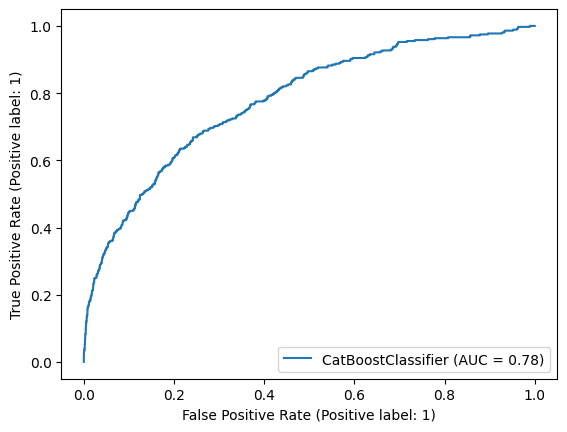

In [84]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

print('AUC = %.2f' % roc_auc_score(y_train.to_numpy(), y_train_pred1['canc_prob']))  #1

metrics.plot_roc_curve(cb, x_test, y_test, ax=plt.gca())  #2
plt.show()